In [1]:
from sixlegged_4 import  *
import pickle as pkl
import time
from FootControl import *

In [2]:
def setleglength(clientID,pole,n,l,wait = True):
    for j in range(3):
        if(wait):
            vrep.simxSetJointTargetPosition(clientID, pole[3*n+j+1], l[j], vrep.simx_opmode_oneshot_wait)
        else:
            vrep.simxSetJointTargetPosition(clientID, pole[3*n+j+1], l[j], vrep.simx_opmode_oneshot)

In [3]:
def setlegspos(clientID,pole,fc,pos):
    pos = fc.posture(pos)
    for i,p in enumerate(pos[:-1]):
        setleglength(clientID,pole,i,p,False)
    setleglength(clientID,pole,5,pos[-1])

In [4]:
def getcurrentl(clientID,pole,n):
    res = []
    for j in range(3):
        _,l = vrep.simxGetJointPosition(clientID, pole[3*n+j+1], vrep.simx_opmode_oneshot_wait)
        res.append(l)
    return np.array(res)

In [5]:
    print('Program started')
    vrep.simxFinish(-1) # just in case, close all opened connections
    clientID=vrep.simxStart('127.0.0.1',19997,True,True,-500000,5) # Connect to V-REP, set a very large time-out for blocking commands
    if clientID!=-1:
        print ('Connected to remote API server')

        emptyBuff = bytearray()

        # Start the simulation:
        vrep.simxStartSimulation(clientID,vrep.simx_opmode_oneshot_wait)
        #Retrive the body
        res, body = vrep.simxGetObjectHandle(clientID, 'body', vrep.simx_opmode_blocking)
        # Retrieve the poles
        pole = np.zeros(19, dtype='int32')
        for i in range(1, 19):
            res, pole[i] = vrep.simxGetObjectHandle(clientID, 'P' + str(i), vrep.simx_opmode_blocking)
        # Retrive the U1
        U1 = np.zeros(6, dtype='int32')
        for i in range(0, 6):
            res, U1[i] = vrep.simxGetObjectHandle(clientID, 'Hip' + str(i + 1), vrep.simx_opmode_blocking)
        # Retrive the U2
        U2 = np.zeros(6, dtype='int32')
        res, U2[0] = vrep.simxGetObjectHandle(clientID, 'shaft2', vrep.simx_opmode_blocking)
        for i in range(1, 6):
            res, U2[i] = vrep.simxGetObjectHandle(clientID, 'shaft2#' + str(i - 1), vrep.simx_opmode_blocking)
        # Retrive the U3
        U3 = np.zeros(6, dtype='int32')
        res, U3[0] = vrep.simxGetObjectHandle(clientID, 'shaft3', vrep.simx_opmode_blocking)
        for i in range(1, 6):
            res, U3[i] = vrep.simxGetObjectHandle(clientID, 'shaft3#' + str(i - 1), vrep.simx_opmode_blocking)
        # Retrive the target Dummy
        target = np.zeros(6, dtype='int32')
        res, target[0] = vrep.simxGetObjectHandle(clientID, 'target_Dummy', vrep.simx_opmode_blocking)
        for i in range(1, 6):
            res, target[i] = vrep.simxGetObjectHandle(clientID, 'target_Dummy#' + str(i - 1), vrep.simx_opmode_blocking)

        #Retrive the support points
        Dummy = np.zeros(6, dtype='int32')
        for i in range(0, 6):
            res, Dummy[i] = vrep.simxGetObjectHandle(clientID, 'Sup_Dummy' + str(i), vrep.simx_opmode_blocking)

        # Retrive the S1
        S1 = np.zeros(6, dtype='int32')
        for i in range(0, 6):
                res, S1[i] = vrep.simxGetObjectHandle(clientID, 'TipSf' + str(i + 1), vrep.simx_opmode_blocking)
        # Retrive the S2
        S2 = np.zeros(6, dtype='int32')
        res, S2[0] = vrep.simxGetObjectHandle(clientID, 'S2', vrep.simx_opmode_blocking)
        for i in range(1, 6):
            res, S2[i] = vrep.simxGetObjectHandle(clientID, 'S2#' + str(i - 1), vrep.simx_opmode_blocking)
        # Retrive the S3
        S3 = np.zeros(6, dtype='int32')
        res, S3[0] = vrep.simxGetObjectHandle(clientID, 'S3', vrep.simx_opmode_blocking)
        for i in range(1, 6):
            res, S3[i] = vrep.simxGetObjectHandle(clientID, 'S3#' + str(i - 1), vrep.simx_opmode_blocking)
        #Retrive the Spheres
        Sf = np.zeros(6, dtype='int32')
        res, Sf[0] = vrep.simxGetObjectHandle(clientID, 'Sphere', vrep.simx_opmode_blocking)
        for i in range(1, 6):
            res, Sf[i] = vrep.simxGetObjectHandle(clientID, 'Sphere#' + str(i - 1), vrep.simx_opmode_blocking)


Program started
Connected to remote API server


## generatedata

In [6]:
#set the length of the legs to maximum, make it higher so the robot can move one leg freely
for i in range(1,19):
    vrep.simxSetJointTargetPosition(clientID, pole[i], 0.3, vrep.simx_opmode_oneshot_wait)
# for i in range(6):
#     vrep.simxSetJointTargetPosition(clientID, pole[1+3*i], 0.05, vrep.simx_opmode_oneshot_wait)

In [11]:
getcurrentl(clientID,pole,0)

array([0.29955542, 0.30010605, 0.30004668])

In [7]:
setleglength(clientID,pole,0,[0.07,0.07,0.07])
def datagen(clientID, pole,fl= "data.pkl"):
    ls = []
    ps = []
    dls = []
    dps = []
    for i in range(2000):    
#     for i in range(2):

        l = np.random.rand((3))/10 -0.5/10
#         print(l)
        curtl = getcurrentl(clientID,pole,0)
        targetl = np.clip(curtl+l,0,0.15)
#         print(targetl)
        ls.append(curtl)
        dls.append(l)
        res, p = vrep.simxGetObjectPosition(clientID,Sf[0],body,vrep.simx_opmode_oneshot_wait)
        ps.append(p)
        l = targetl-curtl
        for j in range(3):
            vrep.simxSetJointTargetPosition(clientID, pole[j+1], targetl[j], vrep.simx_opmode_oneshot_wait)
        time.sleep(0.5)
        res, p_ = vrep.simxGetObjectPosition(clientID,Sf[0],body,vrep.simx_opmode_oneshot_wait)
        dps.append(np.array(p_)-np.array(p))
        if i % 100==0:
            setleglength(clientID,pole,0,np.random.rand((3))/6)
            time.sleep(2)
        if i % 1000 ==0:
            print(i)
    with open(fl,"wb") as f:
        pkl.dump({"ls":ls,"ps":ps,"dls":dls,"dps":dps},f)
for i in range(3,10):
    datagen(clientID,pole,"data{}.pkl".format(i))

0
1000
0
1000
0
1000
0
1000
0
1000
0
1000
0
1000


In [17]:
vrep.simxSetJointTargetPosition(clientID, pole[1], 0.033, vrep.simx_opmode_oneshot_wait)
vrep.simxSetJointTargetPosition(clientID, pole[2], 0.0414, vrep.simx_opmode_oneshot_wait)
vrep.simxSetJointTargetPosition(clientID, pole[3], -0.013, vrep.simx_opmode_oneshot_wait)

0

In [39]:
vrep.simxSetJointTargetPosition(clientID, pole[1], 0.05, vrep.simx_opmode_oneshot_wait)
vrep.simxSetJointTargetPosition(clientID, pole[2], 0.05, vrep.simx_opmode_oneshot_wait)
vrep.simxSetJointTargetPosition(clientID, pole[3], 0.05, vrep.simx_opmode_oneshot_wait)

0

In [4]:
vrep.simxSetJointTargetPosition(clientID, pole[1], -0.03, vrep.simx_opmode_oneshot_wait)
vrep.simxSetJointTargetPosition(clientID, pole[2], -0.03, vrep.simx_opmode_oneshot_wait)
vrep.simxSetJointTargetPosition(clientID, pole[3], -0.03, vrep.simx_opmode_oneshot_wait)

0

In [34]:
vrep.simxGetObjectPosition(clientID,Sf[0],body,vrep.simx_opmode_oneshot_wait)

(0, [0.18063640594482422, 0.09750151634216309, -0.8372083902359009])

In [18]:
vrep.simxFinish(clientID)

In [4]:
from FootControl import *
with open("data.pkl","rb") as f:
    dt = pkl.load(f)
dt[1]
setleglength(clientID,pole,dt[0][1])

TypeError: setleglength() missing 1 required positional argument: 'l'

In [65]:
for i in range(1,19):
    vrep.simxSetJointTargetPosition(clientID, pole[i], 0.02, vrep.simx_opmode_oneshot_wait)

[0.549013614654541, 0.31808793544769287, -0.7146214246749878]
[-0.0003521442413330078, 0.6361125707626343, -0.7136209607124329]
[-0.5523083209991455, 0.32004356384277344, -0.7119673490524292]
[0.5509316921234131, -0.3183860778808594, -0.7139936685562134]
[0.0008549690246582031, -0.6380033493041992, -0.7122920155525208]
[-0.5529499053955078, -0.32013070583343506, -0.7112609148025513]


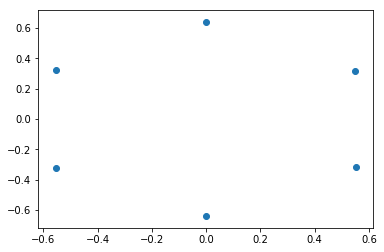

In [42]:
x = []
y = []
for i in range(6):
    res, loc = vrep.simxGetObjectPosition(clientID,Sf[i],body,vrep.simx_opmode_oneshot_wait)
    print(loc)
    x.append(loc[0])
    y.append(loc[1])
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.show()

In [95]:
[x[i]**2+y[i]**2 for i in range(6)]
import math
0.06*math.sin(math.pi/6)

0.029999999999999995

In [12]:
fc = footControler('firstshot3.pt')

## fc,position


In [16]:
l = fc.position(np.array([0.8,0.4, -0.683]),0)
l.detach().numpy()

[ 0.8    0.4   -0.683]


array([0.08493578, 0.01264704, 0.05042491], dtype=float32)

In [17]:
setleglength(clientID,pole,0,l.detach().numpy())

In [18]:
vrep.simxGetObjectPosition(clientID,Sf[0],body,vrep.simx_opmode_oneshot_wait)

(0, [0.7103269100189209, 0.27216482162475586, -0.571845293045044])

## fc, posture

In [13]:
pos = fc.posture([[0.5224435925483704, 0.30223631858825684, -0.6750767827033997],
        [-0.00032013654708862305, 0.6052713394165039, -0.6740224361419678],
[-0.525539755821228, 0.3041713237762451, -0.6725612282752991],
[0.524329423904419, -0.3031071424484253, -0.6743059158325195],
[0.0009336471557617188, -0.606896162033081, -0.6728105545043945],
[-0.5259552597999573, -0.30440330505371094, -0.6719694137573242]])
pos

[ 0.52244359  0.30223632 -0.67507678]
[ 0.52402029  0.30291292 -0.67402244]
[ 0.52618997  0.30304512 -0.67256123]
[ 0.5246632   0.30252903 -0.67430592]
[ 0.52512067  0.30425664 -0.67281055]
[ 0.52595526  0.30440331 -0.67196941]


[array([0.0475618 , 0.04071025, 0.04055893], dtype=float32),
 array([0.04789813, 0.04051695, 0.04045116], dtype=float32),
 array([0.04825853, 0.04020616, 0.04043927], dtype=float32),
 array([0.04798128, 0.04041212, 0.04049251], dtype=float32),
 array([0.0482238 , 0.04042332, 0.04024558], dtype=float32),
 array([0.04836284, 0.04030489, 0.04023526], dtype=float32)]

In [14]:
for i,p in enumerate(pos):
    setleglength(clientID,pole,i,p)

## some calculation

In [67]:
from math import cos, sin,pi
t = math.sqrt(3)
trans = []
for i in range(6):
    angle = i*pi/3
    trans.append(np.array([[cos(angle),-sin(angle)],[sin(angle),cos(angle)]]))
print(trans)
trans[3],trans[5] = trans[5],trans[3]
b = np.array([[-0.5,-t/2],[t/2,-0.5]])
a.dot(b)

[array([[ 1., -0.],
       [ 0.,  1.]]), array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]]), array([[-0.5      , -0.8660254],
       [ 0.8660254, -0.5      ]]), array([[-1.0000000e+00, -1.2246468e-16],
       [ 1.2246468e-16, -1.0000000e+00]]), array([[-0.5      ,  0.8660254],
       [-0.8660254, -0.5      ]]), array([[ 0.5      ,  0.8660254],
       [-0.8660254,  0.5      ]])]


array([0.45677802, 0.45894218])

In [68]:
np.array([x,y]).T.dot(trans)

array([[[ 5.22443593e-01,  3.02236319e-01],
        [ 5.22966126e-01, -3.01331264e-01],
        [ 5.22533570e-04, -6.03567582e-01],
        [-5.22533570e-04,  6.03567582e-01],
        [-5.22966126e-01,  3.01331264e-01],
        [-5.22443593e-01, -3.02236319e-01]],

       [[-3.20136547e-04,  6.05271339e-01],
        [ 5.24020288e-01,  3.02912916e-01],
        [ 5.24340424e-01, -3.02358423e-01],
        [-5.24340424e-01,  3.02358423e-01],
        [-5.24020288e-01, -3.02912916e-01],
        [ 3.20136547e-04, -6.05271339e-01]],

       [[-5.25539756e-01,  3.04171324e-01],
        [ 6.50215582e-04,  6.07216441e-01],
        [ 5.26189971e-01,  3.03045117e-01],
        [-5.26189971e-01, -3.03045117e-01],
        [-6.50215582e-04, -6.07216441e-01],
        [ 5.25539756e-01, -3.04171324e-01]],

       [[ 5.24329424e-01, -3.03107142e-01],
        [-3.33773477e-04, -6.05636172e-01],
        [-5.24663197e-01, -3.02529030e-01],
        [ 5.24663197e-01,  3.02529030e-01],
        [ 3.33773477e-04, 

## modeltest

In [5]:
model = FCnet()

In [12]:
ckpt = torch.load('firstshot3.pt')
model.load_state_dict(ckpt)
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.5681,  0.1762, -0.1741],
        [-0.5011, -0.5248, -0.2617],
        [-0.1923,  0.3536,  0.2615],
        [ 0.1385,  0.0601,  0.4502],
        [-0.0449,  0.1514, -0.0054],
        [ 0.2334,  0.0470,  0.5374],
        [-0.3491, -0.5244, -0.3386],
        [ 0.3446, -0.4368, -0.2554],
        [-0.5186, -0.3362, -0.4779],
        [-0.1083, -0.2455, -0.3190]], requires_grad=True), Parameter containing:
tensor([ 0.1551, -0.2395, -0.3256,  0.3673,  0.3322, -0.5157, -0.2475, -0.5168,
        -0.5017,  0.1732], requires_grad=True), Parameter containing:
tensor([[ 0.1924,  0.2106, -0.1899,  0.2708, -0.0459, -0.1718,  0.2724, -0.2943,
          0.2768,  0.1588],
        [-0.0753, -0.2988,  0.2252,  0.0092,  0.0644, -0.0939,  0.3147, -0.2669,
          0.1151,  0.2522],
        [ 0.3103, -0.0400, -0.1687, -0.2590,  0.1283, -0.0992, -0.1317, -0.2862,
         -0.1793, -0.1540],
        [ 0.1587,  0.1853,  0.1535, -0.2412,  0.1996,  0.1685,  0.2321,  0.0831,
     

In [34]:
x = model.forward(torch.from_numpy(np.array([0, 0, 0])).float())
x

tensor([0.0423, 0.0417, 0.0421], grad_fn=<AddBackward>)

In [30]:
print(model.state_dict.)

<bound method Module.state_dict of FCnet(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
  (tanh): Tanh()
)>


## step

In [20]:
# setlegspos(clientID,pole, 
#[0.55, 0.32, -0.71]
# [-0.00, 0.63, -0.71]
# [-0.55, 0.32, -0.71]
# [0.55, -0.32, -0.71]
# [0.00, -0.63, -0.71]
# [-0.55, -0.32, -0.71]])
for i in range(100):
    setlegspos(clientID,pole,fc,
        [[0.55, 0.32, -0.71],
        [-0.00, 0.63, -0.71],
        [-0.55, 0.32, -0.71],
        [0.55, -0.32, -0.71],
        [0.00, -0.63, -0.71],
        [-0.55, -0.32, -0.71]])
    time.sleep(1)


    setlegspos(clientID,pole,fc,
        [[0.65, 0.32, -0.51],
        [-0.10, 0.63, -0.71],
        [-0.45, 0.32, -0.51],
        [0.45, -0.32, -0.71],
        [0.10, -0.63, -0.51],
        [-0.65, -0.22, -0.71]])
    time.sleep(1)

    setlegspos(clientID,pole,fc,
        [[0.65, 0.32, -0.71],
        [-0.10, 0.63, -0.71],
        [-0.45, 0.32, -0.71],
        [0.45, -0.32, -0.71],
        [0.10, -0.63, -0.71],
        [-0.65, -0.22, -0.71]])
    time.sleep(1)

    setlegspos(clientID,pole,fc,
        [[0.45, 0.32, -0.71],
        [0.10, 0.63, -0.51],
        [-0.65, 0.32, -0.71],
        [0.65, -0.32, -0.51],
        [-0.10, -0.63, -0.71],
        [-0.45, -0.32, -0.51]])
    time.sleep(1)

    setlegspos(clientID,pole,fc,
        [[0.55, 0.32, -0.71],
        [-0.00, 0.63, -0.71],
        [-0.55, 0.32, -0.71],
        [0.55, -0.32, -0.71],
        [0.00, -0.63, -0.71],
        [-0.55, -0.32, -0.71]])
    time.sleep(1)

[ 0.55  0.32 -0.71]
[ 0.545596  0.315    -0.71    ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.545596  0.315    -0.71    ]
[ 0.55  0.32 -0.71]
[ 0.65  0.32 -0.51]
[ 0.495596    0.40160254 -0.71      ]
[ 0.50212813  0.22971143 -0.51      ]
[ 0.50212813  0.22971143 -0.71      ]
[ 0.495596    0.40160254 -0.51      ]
[ 0.65  0.22 -0.71]
[ 0.65  0.32 -0.71]
[ 0.495596    0.40160254 -0.71      ]
[ 0.50212813  0.22971143 -0.71      ]
[ 0.50212813  0.22971143 -0.71      ]
[ 0.495596    0.40160254 -0.71      ]
[ 0.65  0.22 -0.71]
[ 0.45  0.32 -0.71]
[ 0.595596    0.22839746 -0.51      ]
[ 0.60212813  0.40291651 -0.71      ]
[ 0.60212813  0.40291651 -0.51      ]
[ 0.595596    0.22839746 -0.71      ]
[ 0.45  0.32 -0.51]
[ 0.55  0.32 -0.71]
[ 0.545596  0.315    -0.71    ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.545596  0.315    -0.71    ]
[ 0.55  0.32 -0.71]
[ 0.55  0.32 -0.71]
[ 0.545596  0.315    -0.71    ]
[ 0.55212813

[ 0.55  0.32 -0.71]
[ 0.545596  0.315    -0.71    ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.545596  0.315    -0.71    ]
[ 0.55  0.32 -0.71]
[ 0.55  0.32 -0.71]
[ 0.545596  0.315    -0.71    ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.55212813  0.31631397 -0.71      ]
[ 0.545596  0.315    -0.71    ]
[ 0.55  0.32 -0.71]
[ 0.65  0.32 -0.51]
[ 0.495596    0.40160254 -0.71      ]
[ 0.50212813  0.22971143 -0.51      ]
[ 0.50212813  0.22971143 -0.71      ]
[ 0.495596    0.40160254 -0.51      ]
[ 0.65  0.22 -0.71]
[ 0.65  0.32 -0.71]
[ 0.495596    0.40160254 -0.71      ]
[ 0.50212813  0.22971143 -0.71      ]
[ 0.50212813  0.22971143 -0.71      ]
[ 0.495596    0.40160254 -0.71      ]
[ 0.65  0.22 -0.71]
[ 0.45  0.32 -0.71]
[ 0.595596    0.22839746 -0.51      ]
[ 0.60212813  0.40291651 -0.71      ]
[ 0.60212813  0.40291651 -0.51      ]
[ 0.595596    0.22839746 -0.71      ]
[ 0.45  0.32 -0.51]
[ 0.55  0.32 -0.71]
[ 0.545596  0.315    -0.71    ]
[ 0.55212813

KeyboardInterrupt: 

[0.5640466213226318, 0.39428186416625977, -0.6418365836143494]
[0.03803515434265137, 0.6572710275650024, -0.6623495221138]
[-0.6215095520019531, 0.2963109016418457, -0.6416422128677368]
[0.5496177673339844, -0.3666388988494873, -0.6608495712280273]
[0.05195450782775879, -0.6902416944503784, -0.6385135650634766]
[-0.5839602947235107, -0.2920440435409546, -0.6663398146629333]


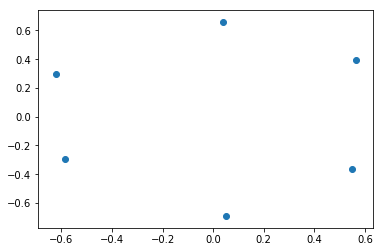

In [50]:
x = []
y = []
for i in range(6):
    res, loc = vrep.simxGetObjectPosition(clientID,Sf[i],body,vrep.simx_opmode_oneshot_wait)
    print(loc)
    x.append(loc[0])
    y.append(loc[1])
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.show()

In [12]:
vrep.simxFinish(clientID)

In [1]:
import actorcritic.robotenv as env

Program started
Connected to remote API server


In [2]:
env.reset()

status 0


[0.4753097593784332,
 0.27459558844566345,
 -0.6867130398750305,
 -0.001184701919555664,
 0.5503119826316833,
 -0.6846808195114136,
 -0.4763985872268677,
 0.2770123779773712,
 -0.6831436157226562,
 0.5021542310714722,
 -0.2927126884460449,
 -0.6660428643226624,
 -0.009460657835006714,
 -0.555100679397583,
 -0.6798773407936096,
 -0.4878655672073364,
 -0.28250449895858765,
 -0.676030695438385,
 0.6579424142837524,
 0.28934746980667114,
 0.7135422825813293,
 -0.0009262022795155644,
 0.006354341749101877,
 2.60868501663208,
 -4.657942414283752,
 3.710652530193329,
 0.67]

In [12]:
env.step([1]*18)

[0.6661397814750671, 0.4103906750679016, 0.6871273517608643] [-4.666139781475067, 3.5896093249320984, 0.67] 5.88711776388953 5.886097402728262
-0.0008349922151928979


([0.5353310108184814,
  0.30760130286216736,
  -0.6203669905662537,
  0.0006272494792938232,
  0.6167913675308228,
  -0.6268263459205627,
  -0.5362210869789124,
  0.30582869052886963,
  -0.6321178078651428,
  0.5350245833396912,
  -0.3100382685661316,
  -0.6374786496162415,
  0.0015737414360046387,
  -0.6195273399353027,
  -0.642920732498169,
  -0.5339527130126953,
  -0.31268322467803955,
  -0.6496277451515198,
  0.6661397814750671,
  0.4103906750679016,
  0.6871273517608643,
  -0.0016555028269067407,
  0.0003149127005599439,
  2.587217330932617,
  -4.666139781475067,
  3.5896093249320984,
  0.67],
 -0.0008349922151928979,
 False,
 None)

In [73]:
env.step([1,1,1,#-0.2 ,0.5,0,   #0.4,-0.10,0.4,
          1,1,1,#0.5,0.8,0,#0.5,0,0.8,
          1,1,1,#0.7,0.8,0.3,#-0.1,0.2,0.4,
          1,1,1, #0.2,0.2,0.6,#0.5,0.6,-0.1,
          1,1,1,#0.5,0,0.8,#0.5,0.8,0,
          1,1,1,#0.7,0.3,0.8 #-0.1,0.2,0.4
         ])

[0.7813825607299805, 0.10526325553655624, 0.8130990862846375] [-4.7813825607299805, 3.8947367444634438, 0.67] 6.166894964301442 5.949291234818946
-7.13297517727085e-05


([0.586330771446228,
  0.33538034558296204,
  -0.7839880585670471,
  -0.001968860626220703,
  0.6792123317718506,
  -0.7806320190429688,
  -0.6729910373687744,
  0.1840720772743225,
  -0.7106759548187256,
  0.584369421005249,
  -0.3374752402305603,
  -0.7846388816833496,
  -0.0002624988555908203,
  -0.67668217420578,
  -0.7828124165534973,
  -0.5884056687355042,
  -0.341001033782959,
  -0.7798025608062744,
  0.7813825607299805,
  0.10526325553655624,
  0.8130990862846375,
  0.0043368106707930565,
  0.0009996223961934447,
  2.1586952209472656,
  -4.7813825607299805,
  3.8947367444634438,
  0.67],
 -7.13297517727085e-05,
 False,
 None)

In [11]:
# env.target
vrep.simxGetObjectPosition(clientID,body,-1,vrep.simx_opmode_oneshot_wait)

(0, [-4.804217338562012, 4.102025032043457, 0.34272950887680054])

In [74]:
env.exit()

try The three three step of HB

In [18]:
env.step([1.3653886318206787,
   1.6193252801895142,
   1.6216754913330078,
   1.2896952033042908,
   1.5188078582286835,
   1.518150120973587,
   1.3653914630413055,
   1.595943570137024,
   1.595313996076584,
   1.2720918655395508,
   1.4987093210220337,
   1.4992019534111023,
   1.3653960824012756,
   1.5949125587940216,
   1.5943413972854614,
   1.2570388615131378,
   1.48155078291893,
   1.4816918969154358])

[0.7323142290115356, 0.14956547319889069, 0.9060632586479187] [-4.732314229011536, 3.8504345268011093, 0.67] 6.1008723972303445 5.955280827518859
0


([0.5313396453857422,
  0.3037255108356476,
  -0.8824895620346069,
  -0.0011937618255615234,
  0.61602383852005,
  -0.8709590435028076,
  -0.544914722442627,
  0.317724347114563,
  -0.8704438209533691,
  0.5344855785369873,
  -0.30768612027168274,
  -0.8683215379714966,
  0.0044065117835998535,
  -0.6259512901306152,
  -0.873152494430542,
  -0.5325341820716858,
  -0.3091559410095215,
  -0.8673312664031982,
  0.7323142290115356,
  0.14956547319889069,
  0.9060632586479187,
  0.0007230202900245786,
  0.012068039737641811,
  2.726376533508301,
  -4.732314229011536,
  3.8504345268011093,
  0.67],
 0,
 False,
 None)

In [19]:
env.step([2.4429957568645477,
   2.3165737092494965,
2.5190144777297974,
1.365393102169037,
1.5916794538497925,
1.5915632247924805,
0.46798910945653915,
0.8769210427999496,
1.1221975088119507,
1.3653790950775146,
1.594083607196808,
1.593860387802124,
1.5180128812789917,
1.9507107138633728,
1.511295884847641,
1.3653866946697235,
1.592758744955063,
1.5930446982383728])

[0.7773398160934448, 0.08134056627750397, 0.934088408946991] [-4.777339816093445, 3.918659433722496, 0.67] 6.178905038591713 5.955280827518859
-0.07803264136136878


([0.5410306453704834,
  0.309856653213501,
  -0.9041381478309631,
  -0.00015717744827270508,
  0.6218435764312744,
  -0.876232922077179,
  -0.5545770525932312,
  0.3223104774951935,
  -0.8209612369537354,
  0.5363984107971191,
  -0.3095148205757141,
  -0.8777929544448853,
  0.1881236433982849,
  -0.6114604473114014,
  -0.8741393089294434,
  -0.5212362408638,
  -0.3070070147514343,
  -0.8829877376556396,
  0.7773398160934448,
  0.08134056627750397,
  0.934088408946991,
  0.08113215118646622,
  0.04901810362935066,
  2.717039108276367,
  -4.777339816093445,
  3.918659433722496,
  0.67],
 -0.07803264136136878,
 False,
 None)

In [20]:
env.step([2.5531065464019775,
   2.4376699328422546,
   2.6423439383506775,
   1.452144980430603,
   1.4356781542301178,
   1.8782323598861694,
   0.5603683367371559,
   0.9659732133150101,
   1.213863417506218,
   2.3706935346126556,
   2.422116994857788,
   2.2212056815624237,
   1.6195695102214813,
   2.050718069076538,
   1.609230786561966,
   0.3554492071270943,
   0.9996610134840012,
   0.7513897120952606])

[0.9145280122756958, 0.08338019251823425, 0.9080413579940796] [-4.914528012275696, 3.9166198074817657, 0.67] 6.284305554299616 5.955280827518859
-0.10540051570790254


([0.6726155877113342,
  0.2723650336265564,
  -0.9282937049865723,
  0.18001145124435425,
  0.6255714893341064,
  -0.8605907559394836,
  -0.3820827603340149,
  0.3305816054344177,
  -0.8624848127365112,
  0.595868706703186,
  -0.34438151121139526,
  -0.8915661573410034,
  0.18913602828979492,
  -0.6163891553878784,
  -0.8832277059555054,
  -0.4013978838920593,
  -0.2799036204814911,
  -0.8630845546722412,
  0.9145280122756958,
  0.08338019251823425,
  0.9080413579940796,
  0.006329894065856934,
  0.028971098363399506,
  2.7899539470672607,
  -4.914528012275696,
  3.9166198074817657,
  0.67],
 -0.10540051570790254,
 False,
 None)

In [21]:
env.step([1.444491595029831,
   1.661871373653412,
   1.677040010690689,
   1.2991324067115784,
   1.5089821815490723,
   1.5473943948745728,
   1.288292109966278,
   1.546439379453659,
   1.5617498755455017,
   1.3610170781612396,
   1.5736818313598633,
   1.557384431362152,
   1.3667750358581543,
   1.6111479699611664,
   1.579267829656601,
   1.1855977028608322,
   1.4394152164459229,
   1.4186826348304749])

[0.8260502815246582, 0.1441621631383896, 0.9185113906860352] [-4.826050281524658, 3.8558378368616104, 0.67] 6.177236173563211 5.955280827518859
0


([0.6577686071395874,
  0.27356988191604614,
  -0.9041410684585571,
  0.015741050243377686,
  0.6158180832862854,
  -0.8720808625221252,
  -0.38934600353240967,
  0.40114694833755493,
  -0.8713729381561279,
  0.6339051723480225,
  -0.30132347345352173,
  -0.8732157349586487,
  0.018081247806549072,
  -0.6025099754333496,
  -0.88458251953125,
  -0.5202876925468445,
  -0.37475332617759705,
  -0.8366563320159912,
  0.8260502815246582,
  0.1441621631383896,
  0.9185113906860352,
  -0.00340655748732388,
  0.030847879126667976,
  2.833341360092163,
  -4.826050281524658,
  3.8558378368616104,
  0.67],
 0,
 False,
 None)

In [69]:
env.step([0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5])

[-0.0013716415269300342, 0.8082152605056763, 0.7744095325469971] [-3.99862835847307, 3.1917847394943237, 0.67] 5.1162993044244285 5.047784359660831
0


([0.5610373020172119,
  0.3239799737930298,
  -0.7432057857513428,
  -0.009285807609558105,
  0.6496032476425171,
  -0.742003321647644,
  -0.5535854697227478,
  0.3380318284034729,
  -0.7417649030685425,
  0.5598185062408447,
  -0.31653890013694763,
  -0.7447038292884827,
  0.0007237792015075684,
  -0.643274188041687,
  -0.744841992855072,
  -0.5599724054336548,
  -0.32193079590797424,
  -0.743406355381012,
  -0.0013716415269300342,
  0.8082152605056763,
  0.7744095325469971,
  0.002266984898597002,
  -0.0030047877226024866,
  1.8897546529769897,
  -3.99862835847307,
  3.1917847394943237,
  0.67],
 0,
 False,
 None)

In [72]:
env.step([1,0.3,0.3,
          0.2,0.8,0.2,
          1,0.3,0.3,
          0.2,0.2,0.7,
          1,0.3,0.3,
          0.4,0.8,0.8])

[0.08155031502246857, 0.9438880085945129, 0.7648528814315796] [-4.081550315022469, 3.056111991405487, 0.67] 5.098909047832921 4.926673612755997
0


([0.6016833782196045,
  0.34582990407943726,
  -0.6929183006286621,
  -0.03560131788253784,
  0.6277207732200623,
  -0.7370905876159668,
  -0.6416275501251221,
  0.36868903040885925,
  -0.6569772362709045,
  0.4932551383972168,
  -0.36278823018074036,
  -0.7435606718063354,
  -0.004515409469604492,
  -0.7417647838592529,
  -0.655339241027832,
  -0.6263566017150879,
  -0.349398672580719,
  -0.713273286819458,
  0.08155031502246857,
  0.9438880085945129,
  0.7648528814315796,
  0.00913926400244236,
  0.009330430068075657,
  2.0082876682281494,
  -4.081550315022469,
  3.056111991405487,
  0.67],
 0,
 False,
 None)

In [60]:
env.step([0.5,0.5,0.5,
          0.2,0.8,0.2,
          0.5,0.5,0.5,
          0.2,0.2,0.8,
          0.5,0.5,0.5,
          0.4,0.8,0.8])

[0.31576064229011536, 0.04666141793131828, 0.7838658094406128] [-4.315760642290115, 3.9533385820686817, 0.67] 5.8527494279195995 5.874484703604442
0.04347055136968514


([0.5559062361717224,
  0.319967657327652,
  -0.7471771240234375,
  -0.13514843583106995,
  0.564184308052063,
  -0.757145881652832,
  -0.5583398938179016,
  0.3240198493003845,
  -0.7440046072006226,
  0.39238107204437256,
  -0.4338889718055725,
  -0.7566670179367065,
  0.00023417174816131592,
  -0.6458019614219666,
  -0.7436500787734985,
  -0.6172543168067932,
  -0.35957303643226624,
  -0.732659637928009,
  0.31576064229011536,
  0.04666141793131828,
  0.7838658094406128,
  0.004193810746073723,
  0.026965435594320297,
  2.510138511657715,
  -4.315760642290115,
  3.9533385820686817,
  0.67],
 0.04347055136968514,
 False,
 None)

In [61]:
env.step([0.5,0.5,0.5,
          0.4,0.7,0.2,
          0.5,0.5,0.5,
          0.4,0.2,0.7,
          0.5,0.5,0.5,
          0.4,0.3,0.3])

[0.2509058713912964, 0.09205912798643112, 0.7785845398902893] [-4.250905871391296, 3.907940872013569, 0.67] 5.7742707406722085 5.8527494279195995
0.1569573744947821


([0.5543992519378662,
  0.3235403299331665,
  -0.746870756149292,
  -0.2227550595998764,
  0.584243655204773,
  -0.7395839095115662,
  -0.5517992377281189,
  0.3138079047203064,
  -0.7496252655982971,
  0.462826132774353,
  -0.4809635877609253,
  -0.715343713760376,
  -0.009535863995552063,
  -0.6430902481079102,
  -0.7438721656799316,
  -0.580753743648529,
  -0.3370007872581482,
  -0.7176337838172913,
  0.2509058713912964,
  0.09205912798643112,
  0.7785845398902893,
  -0.004143810831010342,
  0.0036254534497857094,
  2.429819345474243,
  -4.250905871391296,
  3.907940872013569,
  0.67],
 0.1569573744947821,
 False,
 None)

In [96]:
env.step([0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5])

[0.18644119799137115, 1.1690807342529297, 0.781846284866333] [-4.186441197991371, 2.8309192657470703, 0.67] 5.053750468060068 4.926673612755997
0


([0.5561878681182861,
  0.3208859860897064,
  -0.7469015717506409,
  -0.0001227855682373047,
  0.6430782079696655,
  -0.7458487153053284,
  -0.5465684533119202,
  0.3130366802215576,
  -0.7516888380050659,
  0.5447515249252319,
  -0.3137064576148987,
  -0.752461314201355,
  0.0009046792984008789,
  -0.643602728843689,
  -0.7454277873039246,
  -0.5554776787757874,
  -0.32266920804977417,
  -0.7465047240257263,
  0.18644119799137115,
  1.1690807342529297,
  0.781846284866333,
  0.0008073796052485704,
  0.0043809739872813225,
  1.9300662279129028,
  -4.186441197991371,
  2.8309192657470703,
  0.67],
 0,
 False,
 None)

In [93]:
env.step([0.2,0.8,0.2,
          1,0.3,0.3,
          0.4,0.8,0.8,
          1,0.3,0.3,
          0.2,0.2,0.8,
          1,0.3,0.3,])

[0.18564675748348236, 1.1364245414733887, 0.781035304069519] [-4.185646757483482, 2.8635754585266113, 0.67] 5.071459670066191 4.926673612755997
0


([0.4829797148704529,
  0.36155158281326294,
  -0.7559677362442017,
  0.007005929946899414,
  0.7330178618431091,
  -0.6627432107925415,
  -0.5509461760520935,
  0.35890671610832214,
  -0.7511141300201416,
  0.6055024862289429,
  -0.34772300720214844,
  -0.6885478496551514,
  -0.104331374168396,
  -0.5887852907180786,
  -0.7488800883293152,
  -0.6335274577140808,
  -0.375490665435791,
  -0.661353349685669,
  0.18564675748348236,
  1.1364245414733887,
  0.781035304069519,
  0.0028440747410058975,
  0.007420995272696018,
  1.993840217590332,
  -4.185646757483482,
  2.8635754585266113,
  0.67],
 0,
 False,
 None)

In [94]:
env.step([0.2,0.8,0.2,
          0.5,0.5,0.5,
          0.4,0.8,0.8,
          0.5,0.5,0.5,
          0.2,0.2,0.8,
          0.5,0.5,0.5])

[0.18475894629955292, 1.1712185144424438, 0.7860655188560486] [-4.184758946299553, 2.828781485557556, 0.67] 5.051159483887572 4.926673612755997
0


([0.3701150417327881,
  0.43169260025024414,
  -0.7633624076843262,
  -0.0016410350799560547,
  0.6434714794158936,
  -0.7455152869224548,
  -0.6163859963417053,
  0.3542172908782959,
  -0.7351570129394531,
  0.5568597316741943,
  -0.3234117031097412,
  -0.7452493906021118,
  -0.12998098134994507,
  -0.575093150138855,
  -0.7540572285652161,
  -0.5668649673461914,
  -0.32195234298706055,
  -0.7393559813499451,
  0.18475894629955292,
  1.1712185144424438,
  0.7860655188560486,
  0.027820603922009468,
  0.00400502560660243,
  1.9306113719940186,
  -4.184758946299553,
  2.828781485557556,
  0.67],
 0,
 False,
 None)

In [95]:
env.step([0.4,0.7,0.2,
          0.5,0.5,0.5,
          0.4,0.7,0.7,
          0.5,0.5,0.5,
          0.4,0.2,0.7,
          0.5,0.5,0.5])

[0.19402465224266052, 1.1768560409545898, 0.7873252630233765] [-4.1940246522426605, 2.82314395904541, 0.67] 5.055688340583679 4.926673612755997
-0.004528856696107475


([0.394542932510376,
  0.399339884519577,
  -0.7745533585548401,
  -0.0009074211120605469,
  0.6440927386283875,
  -0.7451612949371338,
  -0.5688971877098083,
  0.3398232161998749,
  -0.7537394762039185,
  0.5609989166259766,
  -0.31710922718048096,
  -0.7448069453239441,
  -0.19300144910812378,
  -0.6089341044425964,
  -0.7302324771881104,
  -0.5243813395500183,
  -0.32681185007095337,
  -0.759341835975647,
  0.19402465224266052,
  1.1768560409545898,
  0.7873252630233765,
  -0.020074259489774704,
  0.00803136732429266,
  1.942502737045288,
  -4.1940246522426605,
  2.82314395904541,
  0.67],
 -0.004528856696107475,
 False,
 None)

In [3]:
import pickle as pkl
import numpy as np
def walkAStep():
    env.step([0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5])
    env.step([1,0.3,0.3,
          0.2,0.8,0.2,
          1,0.3,0.3,
          0.2,0.2,0.7,
          1,0.3,0.3,
          0.4,0.8,0.8])
    env.step([0.5,0.5,0.5,
          0.2,0.8,0.2,
          0.5,0.5,0.5,
          0.2,0.2,0.8,
          0.5,0.5,0.5,
          0.4,0.8,0.8])
    
    env.step([0.5,0.5,0.5,
          0.4,0.7,0.2,
          0.5,0.5,0.5,
          0.4,0.2,0.7,
          0.5,0.5,0.5,
          0.4,0.3,0.3])
    
    env.step([0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5])
    
    env.step([0.2,0.8,0.2,
          1,0.3,0.3,
          0.4,0.8,0.8,
          1,0.3,0.3,
          0.2,0.2,0.8,
          1,0.3,0.3,])
    env.step([0.2,0.8,0.2,
          0.5,0.5,0.5,
          0.4,0.8,0.8,
          0.5,0.5,0.5,
          0.2,0.2,0.8,
          0.5,0.5,0.5])
    env.step([0.4,0.7,0.2,
          0.5,0.5,0.5,
          0.4,0.3,0.3,
          0.5,0.5,0.5,
          0.4,0.2,0.7,
          0.5,0.5,0.5])
walkAStep()
walkAStep()
walkAStep()

[0.668106734752655, 0.2887496054172516, 0.7726244926452637] [-4.668106734752655, 3.7112503945827484, 0.67] 5.963606289681915 5.955280827518859
-0.008325462163056407
[0.6809208393096924, 0.2777717113494873, 0.8051882982254028] [-4.680920839309692, 3.7222282886505127, 0.67] 5.980468488062944 5.955280827518859
-0.016862198381028648
[0.6945688724517822, 0.2680913805961609, 0.817022979259491] [-4.694568872451782, 3.731908619403839, 0.67] 5.99717590552202 5.955280827518859
-0.016707417459076446
[0.6954986453056335, 0.31444329023361206, 0.7924140691757202] [-4.6954986453056335, 3.685556709766388, 0.67] 5.96917379450214 5.955280827518859
0
[0.6941832304000854, 0.32742688059806824, 0.8015540242195129] [-4.6941832304000854, 3.6725731194019318, 0.67] 5.960129991696743 5.955280827518859
0
[0.6630405187606812, 0.38127440214157104, 0.7898136377334595] [-4.663040518760681, 3.618725597858429, 0.67] 5.902467435928785 5.955280827518859
0.1584401747702211
[0.6529291868209839, 0.39614102244377136, 0.79196

In [20]:
def turnleft():
    env.step([0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5])
    env.step([0.1,0.1,0.1,
          0.5,0.9,0.2,
          0.1,0.1,0.1,
          0.5,0.9,0.2,
          0.1,0.1,0.1,
          0.5,0.9,0.2])
    env.step([0.5,0.5,0.5,
          0.5,0.9,0.2,
          0.5,0.5,0.5,
          0.5,0.9,0.2,
          0.5,0.5,0.5,
          0.5,0.9,0.2])
    env.step([0.5,0.5,0.5,
          0.1,-0.2,0.2,
          0.5,0.5,0.5,
          0.1,-0.2,0.2,
          0.5,0.5,0.5,
          0.1,-0.2,0.2,])
    env.step([0.5,0.9,0.2,
          0.1,-0.2,0.2,
          0.5,0.9,0.2,
          0.1,-0.2,0.2,
          0.5,0.9,0.2,
          0.1,-0.2,0.2,])
    env.step([0.5,0.9,0.2,
          0.5,0.2,0.9,
          0.5,0.9,0.2,
          0.5,0.2,0.9,
          0.5,0.9,0.2,
          0.5,0.2,0.9])
    env.step([0.5,0.9,0.2,
          0.5,0.5,0.5,
          0.5,0.9,0.2,
          0.5,0.5,0.5,
          0.5,0.9,0.2,
         0.5,0.5,0.5])
    env.step([0.1,0.1,0.1,
          0.5,0.5,0.5,
          0.1,0.1,0.1,
          0.5,0.5,0.5,
          0.1,0.1,0.1,
         0.5,0.5,0.5])
turnleft()
turnleft()
turnleft()

[0.6606554985046387, 0.24588699638843536, 0.7803926467895508] [-4.660655498504639, 3.7541130036115646, 0.67] 5.9845696687086 5.911344989082249
0
[0.6597939729690552, 0.24496574699878693, 0.7571688890457153] [-4.659793972969055, 3.755034253001213, 0.67] 5.984476761733736 5.911344989082249
0
[0.6624603867530823, 0.24899864196777344, 0.7906070947647095] [-4.662460386753082, 3.7510013580322266, 0.67] 5.984024402189659 5.911344989082249
0
[0.66452556848526, 0.2493649423122406, 0.7890703678131104] [-4.66452556848526, 3.7506350576877594, 0.67] 5.985404089533906 5.911344989082249
-0.0013796873442464275
[0.6649428606033325, 0.2502172589302063, 0.7699049115180969] [-4.6649428606033325, 3.7497827410697937, 0.67] 5.985195276506765 5.911344989082249
0
[0.6632734537124634, 0.25025928020477295, 0.7678205966949463] [-4.663273453712463, 3.749740719795227, 0.67] 5.983867877033198 5.911344989082249
0
[0.6655718684196472, 0.25060251355171204, 0.7723403573036194] [-4.665571868419647, 3.749397486448288, 0.6

In [21]:
def turnright():
    env.step([0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5,
          0.5,0.5,0.5])
    env.step([0.1,0.1,0.1,
          0.5,0.2,0.9,
          0.1,0.1,0.1,
          0.5,0.2,0.9,
          0.1,0.1,0.1,
          0.5,0.2,0.9])
    env.step([0.5,0.5,0.5,
          0.5,0.2,0.9,
          0.5,0.5,0.5,
          0.5,0.2,0.9,
          0.5,0.5,0.5,
          0.5,0.2,0.9])
    env.step([0.5,0.5,0.5,
          0.1,0.2,-0.2,
          0.5,0.5,0.5,
          0.1,0.2,-0.2,
          0.5,0.5,0.5,
          0.1,0.2,-0.2,])
    env.step([0.5,0.2,0.9,
          0.1,0.2,-0.2,
          0.5,0.2,0.9,
          0.1,0.2,-0.2,
          0.5,0.2,0.9,
          0.1,0.2,-0.2,])
    env.step([0.5,0.2,0.9,
          0.5,0.9,0.2,
          0.5,0.2,0.9,
          0.5,0.9,0.2,
          0.5,0.2,0.9,
          0.5,0.9,0.2,])
    env.step([0.5,0.2,0.9,
          0.5,0.5,0.5,
          0.5,0.2,0.9,
          0.5,0.5,0.5,
          0.5,0.2,0.9,
         0.5,0.5,0.5])
    env.step([0.1,0.1,0.1,
          0.5,0.5,0.5,
          0.1,0.1,0.1,
          0.5,0.5,0.5,
          0.1,0.1,0.1,
         0.5,0.5,0.5])
turnright()
turnright()
turnright()


[0.6736496090888977, 0.26045212149620056, 0.7907192707061768] [-4.673649609088898, 3.7395478785037994, 0.67] 5.9855842658974465 5.911344989082249
0
[0.6739256978034973, 0.26344382762908936, 0.7582761645317078] [-4.673925697803497, 3.7365561723709106, 0.67] 5.983931271152022 5.911344989082249
0
[0.6755521893501282, 0.2617471516132355, 0.7902117371559143] [-4.675552189350128, 3.7382528483867645, 0.67] 5.9862611564989825 5.911344989082249
-0.0023298853469606584
[0.6770549416542053, 0.259866327047348, 0.7888174653053284] [-4.677054941654205, 3.740133672952652, 0.67] 5.988609422796441 5.911344989082249
-0.0023482662974583235
[0.6765862107276917, 0.25902462005615234, 0.7702528238296509] [-4.676586210727692, 3.7409753799438477, 0.67] 5.988769103890582 5.911344989082249
-0.00015968109414110643
[0.6762739419937134, 0.2591995894908905, 0.7681179642677307] [-4.676273941993713, 3.7408004105091095, 0.67] 5.988415958484726 5.911344989082249
0
[0.6736589074134827, 0.2580525279045105, 0.77678138017654

In [46]:
def forward():
    env.step([0.5,0.5,0.5,
              0.5,0.5,0.5,
              0.5,0.5,0.5,
              0.5,0.5,0.5,
              0.5,0.5,0.5,
              0.5,0.5,0.5,
    ])
    env.step([-0.2,-0.2,-0.2,#-0.2 ,0.5,0,   #0.4,-0.10,0.4,
          0.5,0.8,0.2,#0.5,0.2,0.8,
          -0.2,-0.2,-0.2, #0.5,0.8,0.2,#-0.1,0.2,0.4,
          0.2,0.2,0.6,#0.5,0.6,-0.1,
          -0.2,-0.2,-0.2,#0.5,0.2,0.8,#0.5,0.8,0.2,
          -0.1,0.2,0.4 #0.5,0.8,0.2
         ])
#     env.step([0.1,0.1,0.1,#-0.2 ,0.5,0,   #0.4,-0.10,0.4,
#           0.5,0.2,0.8,
#           0.1,0.1,0.1, #0.5,0.8,0.2,#-0.1,0.2,0.4,
#           0.5,0.6,-0.1,
#           0.1,0.1,0.1,#0.5,0.2,0.8,#0.5,0.8,0.2,
#           0.5,0.8,0.2
#          ])
    
forward()

[0.7518255114555359, 0.20968671143054962, 0.8027974367141724] [-4.751825511455536, 3.7903132885694504, 0.67] 6.0783485024162465 5.949291234818946
0
[0.7334817051887512, 0.2203717678785324, 0.7755674123764038] [-4.733481705188751, 3.7796282321214676, 0.67] 6.057345840085925 5.949291234818946
0


In [15]:
steps =  [[0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5],
 [1,0.3,0.3,
  0.2,0.8,0.2,
  1,0.3,0.3,
  0.2,0.2,0.7,
  1,0.3,0.3,
  0.4,0.8,0.8],
 [0.5,0.5,0.5,
  0.2,0.8,0.2,
  0.5,0.5,0.5,
  0.2,0.2,0.8,
  0.5,0.5,0.5,
  0.4,0.8,0.8],
 [0.5,0.5,0.5,
  0.5,0.8,0.2,
  0.5,0.5,0.5,
  0.5,0.2,0.7,
  0.5,0.5,0.5,
  0.5,0.4,0.4],
 [0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5,
  0.5,0.5,0.5],
 [0.2,0.8,0.2,
  1,0.3,0.3,
  0.2,0.8,0.8,
  1,0.3,0.3,
  0.4,0.8,0.8,
  1,0.3,0.3,],
 [0.5,0.8,0.2,
  0.5,0.5,0.5,
  0.5,0.2,0.8,
  0.5,0.5,0.5,
  0.5,0.4,0.4,
  0.5,0.5,0.5,]]
steps = np.array(steps)
# steps = steps*0.7
datas = []

def Demonstrgen():
    for k in range(10):
        state = env.reset()
        for i in range(10):
            for j in range(7):
                print(state[0])
                print(steps[j])
                datas.append((state[0],steps[j]))
                state = env.step(steps[j])
    with open("Demondata0.pkl","wb") as f:
        pkl.dump(datas,f)
Demonstrgen()

status 0
0.4753097593784332
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.6635628938674927, 0.28865209221839905, 0.7725993394851685] [-4.663562893867493, 3.711347907781601, 0.67] 5.96011091823404 5.955280827518859
-0.004830090715181257
[0.474709689617157, 0.2717224359512329, -0.7136823534965515, -0.00024512410163879395, 0.5841134786605835, -0.7067415714263916, -0.4822162985801697, 0.2727145254611969, -0.7208772301673889, 0.5055069923400879, -0.2938419580459595, -0.7181646227836609, -0.0023611783981323242, -0.5573835968971252, -0.7299884557723999, -0.5107779502868652, -0.29329240322113037, -0.727574348449707, 0.6635628938674927, 0.28865209221839905, 0.7725993394851685, -0.00010404580825706944, 0.0032367545645684004, 2.608181953430176, -4.663562893867493, 3.711347907781601, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.6826766133308411, 0.3018326163291931, 0.8096138834953308] [-4.682676613330841, 3.698167383670807, 0.67]

[0.6994773149490356, 0.3108057975769043, 0.7797650098800659] [-4.699477314949036, 3.6891942024230957, 0.67] 5.974549430451871 5.955280827518859
-0.0024951350285631335
[0.5690626502037048, 0.3025771379470825, -0.7445124387741089, -0.07387977838516235, 0.6336326003074646, -0.7485597133636475, -0.5408886671066284, 0.32595258951187134, -0.7527599930763245, 0.5584532022476196, -0.32111918926239014, -0.7450615167617798, -0.006229400634765625, -0.6348500847816467, -0.7493041157722473, -0.5568380951881409, -0.32080602645874023, -0.7460457682609558, 0.6994773149490356, 0.3108057975769043, 0.7797650098800659, -0.0016969579737633467, -0.010060909204185009, 2.7671360969543457, -4.699477314949036, 3.6891942024230957, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.6688182353973389, 0.32529693841934204, 0.7846450209617615] [-4.668818235397339, 3.674703061580658, 0.67] 5.94149024285734 5.955280827518859
0.041371753984555504
[0.5184657573699951, 0.4228266775608063, -

[0.5913815498352051, 0.39140522480010986, 0.7698479890823364] [-4.591381549835205, 3.60859477519989, 0.67] 5.839755199301344 5.889062892410057
0.1479230793261399
[0.6355307102203369, 0.36862829327583313, -0.6618533730506897, -0.04152536392211914, 0.6004348993301392, -0.7508952617645264, -0.6468226313591003, 0.3745726943016052, -0.6513524055480957, 0.47695258259773254, -0.36746931076049805, -0.7474581599235535, 0.005421727895736694, -0.7364066243171692, -0.6601644158363342, -0.6163523197174072, -0.3826529383659363, -0.710236668586731, 0.5913815498352051, 0.39140522480010986, 0.7698479890823364, 0.0012623233487829566, 0.04799832031130791, 2.625887155532837, -4.591381549835205, 3.60859477519989, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.5710789561271667, 0.391706645488739, 0.7769685387611389] [-4.571078956127167, 3.608293354511261, 0.67] 5.823619472060203 5.839755199301344
0.04840718172342129
[0.5568574666976929, 0.3188711106777191, -0.746986329555

[0.4651359021663666, 0.3785664439201355, 0.7830122709274292] [-4.465135902166367, 3.6214335560798645, 0.67] 5.749105984926379 5.778945728925444
0.08951923199719491
[0.5164444446563721, 0.42196986079216003, -0.7100925445556641, -0.0023017525672912598, 0.7332221269607544, -0.6633878946304321, -0.5975742340087891, 0.29828080534935, -0.7422436475753784, 0.6338729858398438, -0.3651730418205261, -0.6643085479736328, 0.07837875187397003, -0.5832437872886658, -0.7901043891906738, -0.63929283618927, -0.37045860290527344, -0.6580460071563721, 0.4651359021663666, 0.3785664439201355, 0.7830122709274292, 0.0433381050825119, -0.03965660184621811, 2.593034505844116, -4.465135902166367, 3.6214335560798645, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.49642038345336914, 0.3797239661216736, 0.7781696319580078] [-4.496420383453369, 3.6202760338783264, 0.67] 5.772711219713726 5.749105984926379
-0.023605234787346774
[0.49110931158065796, 0.44341906905174255, -0.7226734

[0.3621979355812073, 0.465687096118927, 0.7835155725479126] [-4.362197935581207, 3.534312903881073, 0.67] 5.614279876505019 5.590975868033441
-0.005868633544318769
[0.56627357006073, 0.32734715938568115, -0.736622154712677, -0.15071424841880798, 0.5525225400924683, -0.7615070939064026, -0.5524677634239197, 0.32276225090026855, -0.7481388449668884, 0.44625893235206604, -0.4457716941833496, -0.7338600158691406, 0.0009400397539138794, -0.6469757556915283, -0.7431303858757019, -0.5963205099105835, -0.23744583129882812, -0.7620266675949097, 0.3621979355812073, 0.465687096118927, 0.7835155725479126, -0.020553499460220337, -0.013346018269658089, 2.721043109893799, -4.362197935581207, 3.534312903881073, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.3329113721847534, 0.4792877733707428, 0.7786765098571777] [-4.332911372184753, 3.520712226629257, 0.67] 5.582968345060243 5.590975868033441
0.024022568919594534
[0.5547084808349609, 0.3129383623600006, -0.7492737

[0.29985737800598145, 0.5433188676834106, 0.7750129699707031] [-4.2998573780059814, 3.4566811323165894, 0.67] 5.517011684028408 5.481964519330788
-0.03504716469762048
[0.442198246717453, 0.481561541557312, -0.7254777550697327, 0.02595868706703186, 0.6578541398048401, -0.7345371246337891, -0.5799362659454346, 0.2533821165561676, -0.755858838558197, 0.5460299253463745, -0.35456424951553345, -0.7385393381118774, 0.035216063261032104, -0.6554582715034485, -0.7320568561553955, -0.559299647808075, -0.31975722312927246, -0.7449207901954651, 0.29985737800598145, 0.5433188676834106, 0.7750129699707031, 0.0058682262897491455, -0.029635805636644363, 2.4170594215393066, -4.2998573780059814, 3.4566811323165894, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.32766440510749817, 0.5501152873039246, 0.7760127782821655] [-4.327664405107498, 3.4498847126960754, 0.67] 5.534472308551965 5.481964519330788
-0.017460624523557122
[0.4770805239677429, 0.4353967010974884, -0.7

[0.1717756688594818, 0.5932643413543701, 0.7759900093078613] [-4.171775668859482, 3.40673565864563, 0.67] 5.386052365060671 5.397169795030428
0.033352289909271526
[0.556988537311554, 0.32009363174438477, -0.7465039491653442, -0.1757609248161316, 0.6151805520057678, -0.729945957660675, -0.548416256904602, 0.32463544607162476, -0.7473598718643188, 0.4398949146270752, -0.4458170533180237, -0.7401154637336731, -0.005954325199127197, -0.656379759311676, -0.7364251017570496, -0.5806078910827637, -0.3380538821220398, -0.7172889709472656, 0.1717756688594818, 0.5932643413543701, 0.7759900093078613, -0.009811385534703732, 0.008411006070673466, 2.5497257709503174, -4.171775668859482, 3.40673565864563, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.18933284282684326, 0.5863990187644958, 0.7798994779586792] [-4.189332842826843, 3.413600981235504, 0.67] 5.4039967919198135 5.386052365060671
-0.01794442685914266
[0.5687518119812012, 0.33670681715011597, -0.733972609

[0.6132045984268188, 0.37411803007125854, 0.7850860357284546] [-4.613204598426819, 3.6258819699287415, 0.67] 5.867595480842274 5.919303443553453
0.15512388813353617
[0.637258768081665, 0.36761292815208435, -0.661034345626831, -0.08534213900566101, 0.5676296353340149, -0.7643327713012695, -0.642309308052063, 0.37347644567489624, -0.654768705368042, 0.4616501033306122, -0.3637910485267639, -0.7574664354324341, -0.000731348991394043, -0.7208080887794495, -0.6722068786621094, -0.5935056805610657, -0.3420696258544922, -0.7377347350120544, 0.6132045984268188, 0.37411803007125854, 0.7850860357284546, -0.0027625311631709337, 0.016515949741005898, 2.535675287246704, -4.613204598426819, 3.6258819699287415, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.5982517600059509, 0.3751971125602722, 0.7874571084976196] [-4.598251760005951, 3.624802887439728, 0.67] 5.855178496099774 5.867595480842274
0.03725095422749991
[0.5564408302307129, 0.3206746578216553, -0.7466379

[0.40101680159568787, 0.5452150106430054, 0.7847498655319214] [-4.401016801595688, 3.4547849893569946, 0.67] 5.595041394897266 5.624801607019744
0.08928063636743477
[0.5195227861404419, 0.44081687927246094, -0.699774444103241, -0.0060994625091552734, 0.7283785343170166, -0.6676669120788574, -0.6088643074035645, 0.25708845257759094, -0.750777542591095, 0.6384902596473694, -0.36935555934906006, -0.6590275764465332, 0.07586291432380676, -0.5728960633277893, -0.7955741286277771, -0.6401543617248535, -0.3719601631164551, -0.6571512818336487, 0.40101680159568787, 0.5452150106430054, 0.7847498655319214, 0.034189898520708084, -0.07492121309041977, 2.1641619205474854, -4.401016801595688, 3.4547849893569946, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.4414733946323395, 0.530998170375824, 0.7773634791374207] [-4.4414733946323395, 3.469001829624176, 0.67] 5.635659642771447 5.595041394897266
-0.040618247874181
[0.44428932666778564, 0.48946118354797363, -0.7184

[0.3585566282272339, 0.6441332101821899, 0.776202917098999] [-4.358556628227234, 3.35586678981781, 0.67] 5.500805194920617 5.5007544731629325
-5.072175768461307e-05
[0.5559985041618347, 0.323989599943161, -0.7438099384307861, -0.054820626974105835, 0.6002064347267151, -0.7440468072891235, -0.561253547668457, 0.3175775706768036, -0.7446913123130798, 0.47236618399620056, -0.3749314546585083, -0.7454667091369629, -0.0011975765228271484, -0.6453513503074646, -0.7444673180580139, -0.6041656732559204, -0.3434857130050659, -0.7435228824615479, 0.3585566282272339, 0.6441332101821899, 0.776202917098999, 0.0015134514542296529, 0.0024879842530936003, 2.2526235580444336, -4.358556628227234, 3.35586678981781, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.3208029866218567, 0.6290271282196045, 0.7770465612411499] [-4.320802986621857, 3.3709728717803955, 0.67] 5.480218659093789 5.5007544731629325
0.061607442207430196
[0.5578626394271851, 0.31893888115882874, -0.746

[0.33049339056015015, 0.7144317626953125, 0.7745136022567749] [-4.33049339056015, 3.2855682373046875, 0.67] 5.435819317055211 5.4035977136581925
-0.032221603397018406
[0.49374788999557495, 0.43300533294677734, -0.7287635207176208, 0.044479548931121826, 0.6523675322532654, -0.7364041209220886, -0.5868416428565979, 0.2572474181652069, -0.7493391036987305, 0.5466848611831665, -0.3446733355522156, -0.7431415319442749, 0.0745893120765686, -0.6200379729270935, -0.7512753009796143, -0.5560745596885681, -0.3224445581436157, -0.7460882067680359, 0.33049339056015015, 0.7144317626953125, 0.7745136022567749, 0.0035476002376526594, -0.00929955393075943, 2.0243351459503174, -4.33049339056015, 3.2855682373046875, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.32898229360580444, 0.7016077637672424, 0.7785027623176575] [-4.328982293605804, 3.2983922362327576, 0.67] 5.44237806867486 5.4035977136581925
-0.00655875161964925
[0.5112200975418091, 0.3786095380783081, -0.74

[0.17331507802009583, 0.8854792714118958, 0.7773039937019348] [-4.173315078020096, 3.1145207285881042, 0.67] 5.207379197757241 5.256166063205509
0.14636059634480247
[0.5512592196464539, 0.32789087295532227, -0.7473029494285583, -0.09754729270935059, 0.6068816184997559, -0.7424392104148865, -0.5853807926177979, 0.3111758232116699, -0.7315660119056702, 0.44900310039520264, -0.475269615650177, -0.7230722308158875, 0.002279043197631836, -0.6347475051879883, -0.7484566569328308, -0.5805956125259399, -0.33294326066970825, -0.719433605670929, 0.17331507802009583, 0.8854792714118958, 0.7773039937019348, 0.012302537448704243, -0.0020765401422977448, 1.9775757789611816, -4.173315078020096, 3.1145207285881042, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.17859652638435364, 0.8968703150749207, 0.7806177139282227] [-4.178596526384354, 3.1031296849250793, 0.67] 5.204813423339458 5.207379197757241
0.00769732325334882
[0.5862890481948853, 0.3028624355792999, -0.73

[0.21411538124084473, 0.9893307685852051, 0.7801951169967651] [-4.214115381240845, 3.010669231414795, 0.67] 5.179082705209333 5.165782115196686
0
[0.5568206310272217, 0.3196795582771301, -0.7468747496604919, 0.022121131420135498, 0.6350967884063721, -0.7483417391777039, -0.5686731338500977, 0.31446725130081177, -0.7413995862007141, 0.5566331148147583, -0.32153964042663574, -0.7459637522697449, 0.006954312324523926, -0.6312924027442932, -0.7507716417312622, -0.5605469346046448, -0.3234778046607971, -0.7433608770370483, 0.21411538124084473, 0.9893307685852051, 0.7801951169967651, 0.009997008368372917, 0.0018980742897838354, 1.930901050567627, -4.214115381240845, 3.010669231414795, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.1617749035358429, 1.038874864578247, 0.7708288431167603] [-4.161774903535843, 2.961125135421753, 0.67] 5.107703242684257 5.165782115196686
0.17423661753728847
[0.6402875781059265, 0.37097930908203125, -0.6586650013923645, -0.0632

[0.6658140420913696, 0.34838777780532837, 0.8039689064025879] [-4.66581404209137, 3.6516122221946716, 0.67] 5.924870673412079 5.954268275777252
0.08819280709551691
[0.43189311027526855, 0.42277991771698, -0.744030237197876, -0.00022730231285095215, 0.7363712191581726, -0.6604337692260742, -0.5586485266685486, 0.2776441276073456, -0.7705119252204895, 0.6357322335243225, -0.37044042348861694, -0.6606854796409607, 0.06770709156990051, -0.572464108467102, -0.797289252281189, -0.6215717196464539, -0.36041486263275146, -0.6736243367195129, 0.6658140420913696, 0.34838777780532837, 0.8039689064025879, 0.021859481930732727, -0.041087791323661804, 2.429534912109375, -4.66581404209137, 3.6516122221946716, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.7140186429023743, 0.3642147481441498, 0.7956133484840393] [-4.714018642902374, 3.63578525185585, 0.67] 5.953226533842271 5.924870673412079
-0.02835586043019145
[0.4740704894065857, 0.44239291548728943, -0.73255610

[0.4442734718322754, 0.46463069319725037, 0.7725156545639038] [-4.444273471832275, 3.5353693068027496, 0.67] 5.678943812709813 5.687441002127028
0.025491568251646335
[0.5548384785652161, 0.32052117586135864, -0.7475028038024902, -0.046974945813417435, 0.6024582982063293, -0.7426830530166626, -0.5664122700691223, 0.3261971175670624, -0.7379816770553589, 0.4783092141151428, -0.3694862127304077, -0.7439988851547241, 0.0012306123971939087, -0.6524991989135742, -0.7390974164009094, -0.6158854365348816, -0.3530454635620117, -0.7354162335395813, 0.4442734718322754, 0.46463069319725037, 0.7725156545639038, 0.0035462933592498302, 0.008138762786984444, 2.353606939315796, -4.444273471832275, 3.5353693068027496, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.4192541241645813, 0.4451912045478821, 0.775384783744812] [-4.419254124164581, 3.554808795452118, 0.67] 5.671549399076887 5.678943812709813
0.022183240898777434
[0.5519087314605713, 0.3272590637207031, -0.747

[0.41573530435562134, 0.5236375331878662, 0.777859091758728] [-4.415735304355621, 3.476362466812134, 0.67] 5.619947889330716 5.588208713016829
-0.03173917631388701
[0.4226449728012085, 0.4949372112751007, -0.7263966798782349, 0.03581331670284271, 0.6529005765914917, -0.7371981143951416, -0.5599893927574158, 0.29340678453445435, -0.7609193921089172, 0.5488290786743164, -0.3524935841560364, -0.7393949031829834, 0.06893423199653625, -0.6060206890106201, -0.7577283978462219, -0.556092381477356, -0.32163572311401367, -0.746353268623352, 0.41573530435562134, 0.5236375331878662, 0.777859091758728, -5.3492803999688476e-05, -0.02465703897178173, 2.2610175609588623, -4.415735304355621, 3.476362466812134, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.39608070254325867, 0.5313186049461365, 0.7802478671073914] [-4.396080702543259, 3.4686813950538635, 0.67] 5.599756795046196 5.588208713016829
0
[0.557094156742096, 0.32053178548812866, -0.7464857697486877, 0.02158

[0.29451996088027954, 0.6959823966026306, 0.7782102823257446] [-4.2945199608802795, 3.3040176033973694, 0.67] 5.418434646460069 5.42032559760139
0.005672853423962287
[0.5449733734130859, 0.32123151421546936, -0.7515124678611755, -0.21598967909812927, 0.6098071932792664, -0.7290858030319214, -0.552291989326477, 0.3188386857509613, -0.7477117776870728, 0.46252545714378357, -0.48090052604675293, -0.715873658657074, -0.001392960548400879, -0.6405712366104126, -0.7456009387969971, -0.5826732516288757, -0.3344789147377014, -0.7174649238586426, 0.29451996088027954, 0.6959823966026306, 0.7782102823257446, -6.489734914794099e-06, 0.00378646538592875, 2.175624370574951, -4.2945199608802795, 3.3040176033973694, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.2969280183315277, 0.6936715841293335, 0.7780489921569824] [-4.296928018331528, 3.3063284158706665, 0.67] 5.421752298686868 5.418434646460069
-0.0033176522267988062
[0.5644837021827698, 0.31201502680778503, -

[0.23871199786663055, 0.7404047250747681, 0.7809043526649475] [-4.2387119978666306, 3.259595274925232, 0.67] 5.347115180840359 5.298219495174779
-0.015740547962960427
[0.5128293037414551, 0.3683289587497711, -0.7519876956939697, 0.0006641745567321777, 0.6433536410331726, -0.7457197904586792, -0.5575035214424133, 0.32199642062187195, -0.7452901005744934, 0.560592770576477, -0.34220951795578003, -0.7366843819618225, -0.010878384113311768, -0.6523023247718811, -0.7395849227905273, -0.5482669472694397, -0.3081270456314087, -0.752459704875946, 0.23871199786663055, 0.7404047250747681, 0.7809043526649475, -0.018658699467778206, 0.004271796904504299, 2.1606459617614746, -4.2387119978666306, 3.259595274925232, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.219476580619812, 0.757347583770752, 0.7780852317810059] [-4.219476580619812, 3.242652416229248, 0.67] 5.321538997966325 5.298219495174779
0
[0.5482292175292969, 0.3303937613964081, -0.7272801995277405, -0.0

[0.20428940653800964, 0.8097345232963562, 0.779772162437439] [-4.20428940653801, 3.190265476703644, 0.67] 5.277674035574275 5.266169980013662
-0.011504055560613402
[0.5672729015350342, 0.3386150002479553, -0.7339668869972229, -0.04882937669754028, 0.6398382782936096, -0.7473047375679016, -0.527918815612793, 0.3122479021549225, -0.7610791325569153, 0.5013567209243774, -0.40841466188430786, -0.7378552556037903, -0.0010325908660888672, -0.6430158615112305, -0.7458703517913818, -0.5575320720672607, -0.32224416732788086, -0.7452536821365356, 0.20428940653800964, 0.8097345232963562, 0.779772162437439, -0.01397763192653656, -0.01480806339532137, 2.1785647869110107, -4.20428940653801, 3.190265476703644, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.18923385441303253, 0.8341568112373352, 0.7833133935928345] [-4.1892338544130325, 3.165843188762665, 0.67] 5.250927859225952 5.266169980013662
0.04572636236313077
[0.4917799234390259, 0.4590701460838318, -0.705223

[0.6978254914283752, 0.32185786962509155, 0.8201397657394409] [-4.697825491428375, 3.6781421303749084, 0.67] 5.966430581105685 5.955280827518859
0
[0.5553486347198486, 0.32396388053894043, -0.7441161274909973, -0.21676266193389893, 0.5054231882095337, -0.7714505195617676, -0.5563406944274902, 0.3221745789051056, -0.7459946274757385, 0.346912145614624, -0.45104360580444336, -0.7637999057769775, 0.0002835988998413086, -0.6431741118431091, -0.7457425594329834, -0.44624465703964233, -0.25530534982681274, -0.8303859829902649, 0.6978254914283752, 0.32185786962509155, 0.8201397657394409, -0.03779052570462227, -0.07554034888744354, 2.6089861392974854, -4.697825491428375, 3.6781421303749084, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.6930834054946899, 0.3219603896141052, 0.8001240491867065] [-4.69308340549469, 3.6780396103858948, 0.67] 5.9626342522829 5.955280827518859
0
[0.48204803466796875, 0.2906048893928528, -0.7852643132209778, -0.2221602201461792, 0

[0.537571370601654, 0.4378851056098938, 0.7764045000076294] [-4.537571370601654, 3.562114894390106, 0.67] 5.7687274562194055 5.724892843082809
-0.04383461313659609
[0.41955825686454773, 0.4944509267807007, -0.7278019785881042, 0.0357903391122818, 0.6522867679595947, -0.7373228073120117, -0.5716236233711243, 0.276123583316803, -0.7549108862876892, 0.5450060367584229, -0.34978795051574707, -0.7421282529830933, 0.06456521153450012, -0.6243714690208435, -0.7502098679542542, -0.5555611848831177, -0.3221927285194397, -0.7464412450790405, 0.537571370601654, 0.4378851056098938, 0.7764045000076294, 0.0017749974504113197, -0.02458716183900833, 2.282095432281494, -4.537571370601654, 3.562114894390106, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5542240738868713, 0.4366268217563629, 0.7757891416549683] [-4.554224073886871, 3.563373178243637, 0.67] 5.782610597524002 5.724892843082809
-0.013883141304596336
[0.4723837971687317, 0.4396114945411682, -0.73860400915

[0.478893518447876, 0.4898853302001953, 0.7740986347198486] [-4.478893518447876, 3.5101146697998047, 0.67] 5.690465020078604 5.689524221050077
-0.0009407990285268397
[0.5561811923980713, 0.32068976759910583, -0.7468499541282654, -0.10301199555397034, 0.6019806265830994, -0.7540044784545898, -0.574367105960846, 0.3219079077243805, -0.7344653010368347, 0.4565391540527344, -0.4127715826034546, -0.7529203295707703, -0.018877193331718445, -0.6694886088371277, -0.7269098162651062, -0.5806485414505005, -0.3411462903022766, -0.7159844636917114, 0.478893518447876, 0.4898853302001953, 0.7740986347198486, -0.01768028363585472, 0.014050189405679703, 2.4219870567321777, -4.478893518447876, 3.5101146697998047, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.4889264702796936, 0.4829193949699402, 0.7771399021148682] [-4.488926470279694, 3.51708060503006, 0.67] 5.702658751657539 5.689524221050077
-0.012193731578935108
[0.5606303215026855, 0.3403244912624359, -0.737415

[0.4445791244506836, 0.5268751978874207, 0.7771456241607666] [-4.444579124450684, 3.4731248021125793, 0.67] 5.6406453074583895 5.5733904291423775
-0.028051653168963853
[0.4987459182739258, 0.41109171509742737, -0.7413762211799622, -0.0001449286937713623, 0.6427984833717346, -0.7460976839065552, -0.5455771088600159, 0.32026010751724243, -0.7503753900527954, 0.5430805683135986, -0.351932168006897, -0.741426944732666, -0.002036869525909424, -0.6450005769729614, -0.7444769740104675, -0.556300699710846, -0.3218020796775818, -0.7461344003677368, 0.4445791244506836, 0.5268751978874207, 0.7771456241607666, -0.007721439935266972, -0.004262764472514391, 2.272397041320801, -4.444579124450684, 3.4731248021125793, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.38701120018959045, 0.5471247434616089, 0.7667060494422913] [-4.3870112001895905, 3.452875256538391, 0.67] 5.582850061375818 5.5733904291423775
0
[0.619471549987793, 0.3728713095188141, -0.673149585723877, -

[0.2960870563983917, 0.6505850553512573, 0.7781510353088379] [-4.296087056398392, 3.3494149446487427, 0.67] 5.447471382906948 5.454484030034585
0.021037941382911818
[0.5824131965637207, 0.3034207224845886, -0.7370195388793945, -0.13776393234729767, 0.6206936240196228, -0.7442654371261597, -0.5570119619369507, 0.3213423788547516, -0.7457982301712036, 0.5601863861083984, -0.330774188041687, -0.740774393081665, -0.007895737886428833, -0.6286312937736511, -0.7527313828468323, -0.5564894676208496, -0.32132112979888916, -0.7461552023887634, 0.2960870563983917, 0.6505850553512573, 0.7781510353088379, -0.005405941046774387, -0.018324360251426697, 2.2396421432495117, -4.296087056398392, 3.3494149446487427, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.2795373797416687, 0.6765481233596802, 0.7808210253715515] [-4.279537379741669, 3.32345187664032, 0.67] 5.4184658862957 5.447471382906948
0.08701648983374355
[0.515713095664978, 0.43596377968788147, -0.703627526

[0.2497936189174652, 0.7340400815010071, 0.7733799815177917] [-4.249793618917465, 3.265959918498993, 0.67] 5.359779845537832 5.323643798480456
0
[0.5215185880661011, 0.36412736773490906, -0.7325717806816101, 0.0036849677562713623, 0.624544620513916, -0.7429060339927673, -0.6322506666183472, 0.3684577941894531, -0.6638937592506409, 0.4828145205974579, -0.40659159421920776, -0.7304428815841675, -6.935000419616699e-05, -0.7426155209541321, -0.6555134654045105, -0.5860111713409424, -0.2759571671485901, -0.7607536315917969, 0.2497936189174652, 0.7340400815010071, 0.7733799815177917, -0.016906259581446648, -0.019496401771903038, 2.3054006099700928, -4.249793618917465, 3.265959918498993, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.26122090220451355, 0.7367116212844849, 0.7847070097923279] [-4.2612209022045135, 3.263288378715515, 0.67] 5.36722038116979 5.323643798480456
-0.007440535631957346
[0.5424065589904785, 0.33084139227867126, -0.7500874996185303, -

[0.08965551108121872, 0.873766303062439, 0.7814947366714478] [-4.089655511081219, 3.126233696937561, 0.67] 5.14768096594815 5.177184899950895
0.08851180200823361
[0.4927522540092468, 0.44832688570022583, -0.7088007926940918, -0.00011754035949707031, 0.7338692545890808, -0.6624773740768433, -0.6122711896896362, 0.26925280690193176, -0.7463884949684143, 0.6381924152374268, -0.3664160370826721, -0.6601062417030334, 0.09106642007827759, -0.5985049605369568, -0.7803757190704346, -0.6454770565032959, -0.3672972321510315, -0.6552910208702087, 0.08965551108121872, 0.873766303062439, 0.7814947366714478, 0.02735671028494835, -0.06510446220636368, 2.0395779609680176, -4.089655511081219, 3.126233696937561, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.11612079292535782, 0.8552508354187012, 0.7740164399147034] [-4.116120792925358, 3.144749164581299, 0.67] 5.179951514260269 5.14768096594815
-0.03227054831211884
status 0
0.4753097593784332
[0.5 0.5 0.5 0.5 0.5 0.5

[0.564010500907898, 0.34064537286758423, 0.7774947285652161] [-4.564010500907898, 3.6593546271324158, 0.67] 5.849877617481667 5.882226221169986
0.09704581106495613
[0.5531148314476013, 0.3248908519744873, -0.7470977306365967, -0.1999220848083496, 0.6036704778671265, -0.7328271269798279, -0.5596907734870911, 0.3018467128276825, -0.7488166093826294, 0.4339275062084198, -0.4533243775367737, -0.7381402254104614, -0.011375844478607178, -0.6381537318229675, -0.7471429109573364, -0.5825766324996948, -0.3354247808456421, -0.7170338034629822, 0.564010500907898, 0.34064537286758423, 0.7774947285652161, 0.0016715017845854163, 0.0021646677050739527, 2.6088221073150635, -4.564010500907898, 3.6593546271324158, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5683631896972656, 0.34035763144493103, 0.7776930332183838] [-4.568363189697266, 3.659642368555069, 0.67] 5.853454065652547 5.849877617481667
-0.0035764481708797646
[0.5733862519264221, 0.30856403708457947, -0.74

[0.5691595673561096, 0.4314498007297516, 0.7801146507263184] [-4.56915956735611, 3.5685501992702484, 0.67] 5.797565840650161 5.752151346748042
-0.009406826508009836
[0.5572845339775085, 0.3200264871120453, -0.7463963627815247, 0.0026591718196868896, 0.6427943110466003, -0.7462136745452881, -0.548889696598053, 0.3171609044075012, -0.7492007613182068, 0.5491973161697388, -0.31746232509613037, -0.7489040493965149, 6.124377250671387e-05, -0.6436414122581482, -0.7454296946525574, -0.5569425821304321, -0.32207441329956055, -0.7455914616584778, 0.5691595673561096, 0.4314498007297516, 0.7801146507263184, -0.0007071269210428, 0.0018278051866218448, 2.639861583709717, -4.56915956735611, 3.5685501992702484, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.5012967586517334, 0.4234396517276764, 0.7704218029975891] [-4.501296758651733, 3.5765603482723236, 0.67] 5.749213549198051 5.752151346748042
0.008813392649974716
[0.6369043588638306, 0.36991578340530396, -0.6598

[0.44505199790000916, 0.5336413383483887, 0.7776883840560913] [-4.445051997900009, 3.4663586616516113, 0.67] 5.63685458702298 5.636899835341295
0.00013574495494594885
[0.5605711936950684, 0.3146911859512329, -0.7452720999717712, -0.04351644217967987, 0.6363813877105713, -0.7495067119598389, -0.5435070991516113, 0.32731205224990845, -0.7507689595222473, 0.5598008632659912, -0.32558804750442505, -0.7425328493118286, -0.007365435361862183, -0.6414644718170166, -0.7459439039230347, -0.5558689832687378, -0.32031524181365967, -0.7463862299919128, 0.44505199790000916, 0.5336413383483887, 0.7776883840560913, -0.002144858008250594, 0.0006239779759198427, 2.613783121109009, -4.445051997900009, 3.4663586616516113, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.4197157323360443, 0.5506273508071899, 0.7830784916877747] [-4.419715732336044, 3.44937264919281, 0.67] 5.606430132237283 5.63685458702298
0.09127336435709132
[0.5093110799789429, 0.43397724628448486, -0.7

[0.38732755184173584, 0.6197541952133179, 0.7714337110519409] [-4.387327551841736, 3.380245804786682, 0.67] 5.538474947846885 5.544620767824193
0.018437459931922362
[0.6119049787521362, 0.35588592290878296, -0.6888100504875183, -0.05254925787448883, 0.617449164390564, -0.7468458414077759, -0.6279297471046448, 0.3652612268924713, -0.6681748628616333, 0.480175256729126, -0.35518980026245117, -0.7547684907913208, 0.0011074542999267578, -0.7449224591255188, -0.6532727479934692, -0.625959038734436, -0.35844630002975464, -0.7136916518211365, 0.38732755184173584, 0.6197541952133179, 0.7714337110519409, -9.847373439697549e-05, 0.029455194249749184, 2.6729965209960938, -4.387327551841736, 3.380245804786682, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.3760142922401428, 0.6176683306694031, 0.7759570479393005] [-4.376014292240143, 3.382331669330597, 0.67] 5.530792764807474 5.538474947846885
0.02304654911823345
[0.5568356513977051, 0.3213164210319519, -0.74617

[0.3008396625518799, 0.7585204839706421, 0.7826437950134277] [-4.30083966255188, 3.241479516029358, 0.67] 5.385574366380738 5.413885530406813
0.08493349207822476
[0.5106167793273926, 0.44065216183662415, -0.7066432237625122, -0.00612834095954895, 0.7308613061904907, -0.6653687953948975, -0.5977579355239868, 0.28823578357696533, -0.745058536529541, 0.6393311023712158, -0.37210404872894287, -0.657221794128418, 0.09209221601486206, -0.5777952075004578, -0.7884571552276611, -0.6344324350357056, -0.3699184060096741, -0.6616628170013428, 0.3008396625518799, 0.7585204839706421, 0.7826437950134277, 0.03527505323290825, -0.051908377557992935, 2.3908183574676514, -4.30083966255188, 3.241479516029358, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.32838204503059387, 0.752160906791687, 0.7779942750930786] [-4.328382045030594, 3.247839093208313, 0.67] 5.41140923448924 5.385574366380738
-0.025834868108502107
[0.4194287359714508, 0.5006253123283386, -0.722528576850

[0.252872109413147, 0.7860233187675476, 0.7837058305740356] [-4.252872109413147, 3.2139766812324524, 0.67] 5.330719209124618 5.297067195785207
-0.005976766178501514
[0.5490172505378723, 0.34249675273895264, -0.7412503957748413, -0.12000535428524017, 0.5564426183700562, -0.7649471759796143, -0.5570698976516724, 0.3203563392162323, -0.7462031841278076, 0.45444822311401367, -0.4320318102836609, -0.7346419095993042, -0.008016720414161682, -0.6480804681777954, -0.7423831224441528, -0.6012493968009949, -0.22525125741958618, -0.759635329246521, 0.252872109413147, 0.7860233187675476, 0.7837058305740356, -0.02246318757534027, -0.009938303381204605, 2.632228136062622, -4.252872109413147, 3.2139766812324524, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.21577024459838867, 0.8087032437324524, 0.778608500957489] [-4.215770244598389, 3.1912967562675476, 0.67] 5.287446807468131 5.297067195785207
0.0288611649512287
[0.5580071210861206, 0.3198418915271759, -0.745963

[0.6923973560333252, 0.27469196915626526, 0.7978801131248474] [-4.692397356033325, 3.7253080308437347, 0.67] 5.9913698660304195 5.955280827518859
0
[0.5552947521209717, 0.3211803138256073, -0.7470692992210388, -0.0009798109531402588, 0.6214146614074707, -0.7570890784263611, -0.5571618676185608, 0.3193368911743164, -0.7464173436164856, 0.5570244789123535, -0.3203471302986145, -0.746222198009491, 0.0009534955024719238, -0.5836549401283264, -0.7751128077507019, -0.5569765567779541, -0.3212771415710449, -0.7458449006080627, 0.6923973560333252, 0.27469196915626526, 0.7978801131248474, 0.02542886696755886, 0.01842471770942211, 2.569396734237671, -4.692397356033325, 3.7253080308437347, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.6229809522628784, 0.2863662838935852, 0.7858325839042664] [-4.622980952262878, 3.713633716106415, 0.67] 5.929842178539639 5.955280827518859
0.07631594693765997
[0.6371132135391235, 0.37047332525253296, -0.6599328517913818, -0.053

[0.43236416578292847, 0.3531476557254791, 0.7800494432449341] [-4.4323641657829285, 3.646852344274521, 0.67] 5.739806975766447 5.729399711841409
-0.010407263925038102
[0.5811681747436523, 0.3133491575717926, -0.7346332669258118, -0.12424694001674652, 0.6246294379234314, -0.7442152500152588, -0.5573452711105347, 0.32120704650878906, -0.7456920146942139, 0.5559109449386597, -0.33633601665496826, -0.7415679693222046, -0.007566526532173157, -0.6256775856018066, -0.7543189525604248, -0.5577967762947083, -0.320107102394104, -0.7458013296127319, 0.43236416578292847, 0.3531476557254791, 0.7800494432449341, -0.0054249996319413185, -0.02363608218729496, 2.5120136737823486, -4.4323641657829285, 3.646852344274521, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.4131072163581848, 0.3654360771179199, 0.7818818688392639] [-4.413107216358185, 3.63456392288208, 0.67] 5.717129543100161 5.729399711841409
0.036810506223742934
[0.49831217527389526, 0.4448580741882324, -0.

[0.4174206852912903, 0.45987874269485474, 0.7723461389541626] [-4.41742068529129, 3.5401212573051453, 0.67] 5.660924308561556 5.620196743251253
0
[0.5251355171203613, 0.3612622022628784, -0.7314733266830444, 0.004853866994380951, 0.6176403164863586, -0.7452849745750427, -0.6306095123291016, 0.3650398254394531, -0.6663960814476013, 0.5019664764404297, -0.4145964980125427, -0.7203969955444336, 0.0006662607192993164, -0.7483883500099182, -0.6504365801811218, -0.6025263071060181, -0.26037436723709106, -0.7543051242828369, 0.4174206852912903, 0.45987874269485474, 0.7723461389541626, -0.017809858545660973, -0.02127550169825554, 2.5073773860931396, -4.41742068529129, 3.5401212573051453, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.43044495582580566, 0.4665716588497162, 0.7830920219421387] [-4.430444955825806, 3.533428341150284, 0.67] 5.666917887939296 5.620196743251253
-0.0059935793777396995
[0.5485649108886719, 0.331830769777298, -0.7460662126541138, -0.

[0.2645703852176666, 0.5613619089126587, 0.7853370904922485] [-4.264570385217667, 3.4386380910873413, 0.67] 5.478210701675534 5.496643321561676
0.05529785965842393
[0.48689183592796326, 0.46596336364746094, -0.7039042711257935, -0.0009881556034088135, 0.7388125061988831, -0.6583297848701477, -0.5963162183761597, 0.2504085898399353, -0.7603071928024292, 0.6343746185302734, -0.3660052418708801, -0.6628478169441223, 0.07494357228279114, -0.5903010368347168, -0.7874045968055725, -0.6409776210784912, -0.3670148253440857, -0.6582142114639282, 0.2645703852176666, 0.5613619089126587, 0.7853370904922485, 0.0337182879447937, -0.07198789715766907, 2.170274257659912, -4.264570385217667, 3.4386380910873413, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.31272512674331665, 0.5452386140823364, 0.7788701057434082] [-4.312725126743317, 3.4547613859176636, 0.67] 5.525846021422502 5.478210701675534
-0.04763531974696722
[0.4221542477607727, 0.49787113070487976, -0.72472

[0.22031399607658386, 0.649728000164032, 0.7743579745292664] [-4.220313996076584, 3.350271999835968, 0.67] 5.388448078840957 5.397099320497276
0.025953724968955427
[0.5549941062927246, 0.32179227471351624, -0.7471977472305298, -0.058245331048965454, 0.5986627340316772, -0.7444173097610474, -0.5633091330528259, 0.32738205790519714, -0.7390576004981995, 0.4743187129497528, -0.367975652217865, -0.7453010678291321, -0.0026819705963134766, -0.6517648100852966, -0.7401285171508789, -0.6179196834564209, -0.357943058013916, -0.7324464917182922, 0.22031399607658386, 0.649728000164032, 0.7743579745292664, 0.005309233441948891, 0.01386889349669218, 2.2568790912628174, -4.220313996076584, 3.350271999835968, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.17415936291217804, 0.6303430795669556, 0.775331437587738] [-4.174159362912178, 3.3696569204330444, 0.67] 5.364531121021642 5.388448078840957
0.07175087345794573
[0.5514247417449951, 0.31600797176361084, -0.750585

[0.20848889648914337, 0.6964352130889893, 0.783169150352478] [-4.208488896489143, 3.3035647869110107, 0.67] 5.350226078698992 5.296771511847496
-0.05345456685149674
[0.511748731136322, 0.4416922926902771, -0.709052324295044, 0.01663804054260254, 0.6620771288871765, -0.7324777245521545, -0.5217310190200806, 0.3332519829273224, -0.7681863903999329, 0.556786298751831, -0.33275550603866577, -0.7397903800010681, -0.002092719078063965, -0.6709052324295044, -0.7182503938674927, -0.5562376976013184, -0.32175213098526, -0.7461869120597839, 0.20848889648914337, 0.6964352130889893, 0.783169150352478, -0.00211791112087667, -0.039967212826013565, 2.3685097694396973, -4.208488896489143, 3.3035647869110107, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.2199425995349884, 0.6972551345825195, 0.7789920568466187] [-4.219942599534988, 3.3027448654174805, 0.67] 5.358734849702087 5.296771511847496
-0.008508771003094218
[0.5575308799743652, 0.3202744126319885, -0.74622428

[0.6925798654556274, 0.3314683437347412, 0.8036938905715942] [-4.692579865455627, 3.668531656265259, 0.67] 5.956377280419691 5.955280827518859
0
[0.5073316097259521, 0.2971789538860321, -0.7740667462348938, 0.0010296404361724854, 0.6432650089263916, -0.745788037776947, -0.5554646849632263, 0.32144269347190857, -0.7468117475509644, 0.5568352937698364, -0.32256919145584106, -0.7456422448158264, 0.0007399320602416992, -0.6437060236930847, -0.7454731464385986, -0.5093979835510254, -0.2906763553619385, -0.7737552523612976, 0.6925798654556274, 0.3314683437347412, 0.8036938905715942, -0.04930375888943672, 0.0016522284131497145, 2.6077523231506348, -4.692579865455627, 3.668531656265259, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.6658768653869629, 0.34963488578796387, 0.8040855526924133] [-4.665876865386963, 3.650365114212036, 0.67] 5.924151617743212 5.955280827518859
0.09338762932693978
[0.42780813574790955, 0.43457794189453125, -0.7408021092414856, -0.0

[0.8089982867240906, 0.4899519383907318, 0.7736027240753174] [-4.808998286724091, 3.510048061609268, 0.67] 5.953730084285164 5.924151617743212
0
[0.6379806995391846, 0.3692891001701355, -0.6593747735023499, -0.07427006959915161, 0.5958927869796753, -0.7470240592956543, -0.6323744058609009, 0.3688849210739136, -0.6640544533729553, 0.4792304039001465, -0.3620752692222595, -0.745205819606781, -0.0004418492317199707, -0.7515639662742615, -0.6476283073425293, -0.6191432476043701, -0.3348401188850403, -0.7291668653488159, 0.8089982867240906, 0.4899519383907318, 0.7736027240753174, -0.001915361499413848, 0.01066681556403637, 2.73057222366333, -4.808998286724091, 3.510048061609268, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.8007396459579468, 0.48835381865501404, 0.7766774892807007] [-4.800739645957947, 3.511646181344986, 0.67] 5.948004711769086 5.924151617743212
0
[0.5556230545043945, 0.3230275809764862, -0.7461698651313782, -0.07191383838653564, 0.59175

[0.7067075371742249, 0.5479717254638672, 0.7841528058052063] [-4.706707537174225, 3.452028274536133, 0.67] 5.836916570304013 5.8500938417760295
0.03953181441604858
[0.4996033310890198, 0.45850956439971924, -0.702329695224762, 0.0035069286823272705, 0.7319930791854858, -0.6643106341362, -0.5960114002227783, 0.2513100504875183, -0.7556060552597046, 0.6292431354522705, -0.36412185430526733, -0.6672601699829102, 0.07655343413352966, -0.6000004410743713, -0.7828605771064758, -0.6355714201927185, -0.36199045181274414, -0.6632328629493713, 0.7067075371742249, 0.5479717254638672, 0.7841528058052063, 0.032753631472587585, -0.05473776534199715, 2.446096181869507, -4.706707537174225, 3.452028274536133, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.7476025819778442, 0.5585905313491821, 0.7776661515235901] [-4.747602581977844, 3.441409468650818, 0.67] 5.8637044099547 5.836916570304013
-0.02678783965068643
[0.41767066717147827, 0.4977080821990967, -0.726164877414

[0.6193927526473999, 0.6383050680160522, 0.774429440498352] [-4.6193927526474, 3.3616949319839478, 0.67] 5.71312368314724 5.721626589769678
0.0255087198673154
[0.5548067092895508, 0.3186604380607605, -0.7475671768188477, -0.06037484109401703, 0.5993292331695557, -0.743720293045044, -0.5589934587478638, 0.332802951335907, -0.7402206659317017, 0.48215895891189575, -0.36054253578186035, -0.7451715469360352, -0.004005342721939087, -0.6495261192321777, -0.7409242987632751, -0.6036155819892883, -0.3623621463775635, -0.7385006546974182, 0.6193927526473999, 0.6383050680160522, 0.774429440498352, 0.0016402874607592821, 0.007821586914360523, 2.5246312618255615, -4.6193927526474, 3.3616949319839478, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.5780905485153198, 0.6074752807617188, 0.7753456234931946] [-4.57809054851532, 3.3925247192382812, 0.67] 5.698081873845626 5.71312368314724
0.04512542790484009
[0.5534351468086243, 0.3234865665435791, -0.7474686503410339

[0.6167130470275879, 0.6935840845108032, 0.7751580476760864] [-4.616713047027588, 3.3064159154891968, 0.67] 5.67859362560793 5.635982829117307
-0.04261079649062349
[0.4282245934009552, 0.49875348806381226, -0.722335159778595, 0.02974560856819153, 0.659542977809906, -0.7338664531707764, -0.5645043849945068, 0.29560673236846924, -0.7514732480049133, 0.5545281171798706, -0.33101797103881836, -0.7416450381278992, -0.0024796128273010254, -0.6712711453437805, -0.7179839015007019, -0.5574023723602295, -0.32235944271087646, -0.7452602982521057, 0.6167130470275879, 0.6935840845108032, 0.7751580476760864, 0.00731656514108181, -0.020411662757396698, 2.4186556339263916, -4.616713047027588, 3.3064159154891968, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.6259636282920837, 0.6913504004478455, 0.775274395942688] [-4.625963628292084, 3.3086495995521545, 0.67] 5.687416079635628 5.635982829117307
-0.008822454027697546
[0.4984579384326935, 0.40906548500061035, -0.741

[0.4455179274082184, 0.814827561378479, 0.7745041251182556] [-4.445517927408218, 3.185172438621521, 0.67] 5.468816426491387 5.491446090080629
0.0678889907677247
[0.5551925897598267, 0.32537907361984253, -0.7458373308181763, -0.07827168703079224, 0.6102617979049683, -0.7395756244659424, -0.5783820152282715, 0.31791192293167114, -0.7342479228973389, 0.4613736569881439, -0.45401036739349365, -0.7270417213439941, 0.012197911739349365, -0.6393945813179016, -0.7453221082687378, -0.5664240121841431, -0.3435170650482178, -0.726703941822052, 0.4455179274082184, 0.814827561378479, 0.7745041251182556, 0.01445203460752964, 0.0020929083693772554, 2.21492862701416, -4.445517927408218, 3.185172438621521, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.4582090973854065, 0.8183576464653015, 0.7803189754486084] [-4.4582090973854065, 3.1816423535346985, 0.67] 5.477086490262484 5.468816426491387
-0.008270063771096403
[0.5765841007232666, 0.30972784757614136, -0.738374114

[0.687411904335022, 0.2811789810657501, 0.810657799243927] [-4.687411904335022, 3.71882101893425, 0.67] 5.983432136472248 5.955280827518859
-0.023303835846100185
[0.5227466821670532, 0.3076179027557373, -0.7414543628692627, -0.1808066964149475, 0.5272330045700073, -0.7690581679344177, -0.5726408362388611, 0.32923996448516846, -0.7128962278366089, 0.3832378387451172, -0.4269060492515564, -0.7626463770866394, 0.0016034245491027832, -0.6783279776573181, -0.7016181945800781, -0.43377411365509033, -0.2578004002571106, -0.8337875604629517, 0.687411904335022, 0.2811789810657501, 0.810657799243927, 0.007499484345316887, -0.10523714125156403, 2.611814498901367, -4.687411904335022, 3.71882101893425, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.6987074017524719, 0.31744319200515747, 0.8199468851089478] [-4.698707401752472, 3.6825568079948425, 0.67] 5.969847225130023 5.955280827518859
0
[0.5570526123046875, 0.3234662711620331, -0.7433472275733948, -0.210704565

[0.756294846534729, 0.43789640069007874, 0.784493088722229] [-4.756294846534729, 3.5621035993099213, 0.67] 5.942299447132357 5.926048927657796
0
[0.5011352896690369, 0.4376152753829956, -0.7079940438270569, 0.0023200809955596924, 0.7457455396652222, -0.652902364730835, -0.6015772819519043, 0.2726414203643799, -0.7532158493995667, 0.637840986251831, -0.37080520391464233, -0.6588771343231201, 0.08243066072463989, -0.581458330154419, -0.7896366119384766, -0.6378143429756165, -0.3642517328262329, -0.6610008478164673, 0.756294846534729, 0.43789640069007874, 0.784493088722229, 0.046344660222530365, -0.05030196160078049, 2.512268304824829, -4.756294846534729, 3.5621035993099213, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.7912395000457764, 0.43454521894454956, 0.7783870100975037] [-4.791239500045776, 3.5654547810554504, 0.67] 5.972306400591824 5.926048927657796
-0.030006953459467134
[0.42335423827171326, 0.49093323945999146, -0.7286549210548401, 0.035995

[0.7947170734405518, 0.48369231820106506, 0.7832285165786743] [-4.794717073440552, 3.516307681798935, 0.67] 5.945900396695233 5.885640231913372
-0.004428017529572337
[0.5432143807411194, 0.33880871534347534, -0.7463902235031128, -0.11730200052261353, 0.5615869164466858, -0.762126088142395, -0.5596958994865417, 0.31885793805122375, -0.7451040148735046, 0.44909822940826416, -0.4296700358390808, -0.7377611994743347, -0.005019187927246094, -0.6484166383743286, -0.7420833110809326, -0.6027556657791138, -0.23530912399291992, -0.7576415538787842, 0.7947170734405518, 0.48369231820106506, 0.7832285165786743, -0.022036610171198845, -0.010114534758031368, 2.6788527965545654, -4.794717073440552, 3.516307681798935, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.7536841630935669, 0.5047358274459839, 0.7775692939758301] [-4.753684163093567, 3.495264172554016, 0.67] 5.900371577992889 5.885640231913372
0
[0.5507370233535767, 0.32088059186935425, -0.7486396431922913, 

[0.7113737463951111, 0.5793312788009644, 0.7760348320007324] [-4.711373746395111, 3.4206687211990356, 0.67] 5.822200363987016 5.788628055906788
-0.033572308080228375
[0.43659478425979614, 0.48657146096229553, -0.7254249453544617, 0.03960774838924408, 0.6540119647979736, -0.7358107566833496, -0.5834759473800659, 0.2522695064544678, -0.753640353679657, 0.5452183485031128, -0.3515697717666626, -0.7415741086006165, 0.05953517556190491, -0.616371214389801, -0.7528738379478455, -0.556560754776001, -0.3238409757614136, -0.7452653050422668, 0.7113737463951111, 0.5793312788009644, 0.7760348320007324, 0.003220466198399663, -0.01897137612104416, 2.3640735149383545, -4.711373746395111, 3.4206687211990356, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.7136028409004211, 0.5426223874092102, 0.779958963394165] [-4.713602840900421, 3.45737761259079, 0.67] 5.845640400998723 5.788628055906788
-0.023440037011706494
[0.5032737851142883, 0.380754292011261, -0.75219160318

[0.5763304233551025, 0.5985296368598938, 0.774983286857605] [-4.5763304233551025, 3.401470363140106, 0.67] 5.701999717208514 5.700845343948383
-0.0011543732601309031
[0.5522376894950867, 0.31827494502067566, -0.7496387958526611, -0.21355022490024567, 0.6149106621742249, -0.7260832190513611, -0.5453784465789795, 0.3232887089252472, -0.7495381236076355, 0.44209569692611694, -0.452059268951416, -0.7375553846359253, -0.009951278567314148, -0.6600525975227356, -0.7336742877960205, -0.5827362537384033, -0.3332900404930115, -0.7177133560180664, 0.5763304233551025, 0.5985296368598938, 0.774983286857605, -0.014791889116168022, 0.007835163734853268, 2.5152876377105713, -4.5763304233551025, 3.401470363140106, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.5918278694152832, 0.592469334602356, 0.7792656421661377] [-4.591827869415283, 3.407530665397644, 0.67] 5.718054600820476 5.700845343948383
-0.016054883611961834
[0.564938485622406, 0.3410332500934601, -0.73470

[0.6055771112442017, 0.673546552658081, 0.776198148727417] [-4.605577111244202, 3.326453447341919, 0.67] 5.681252772492122 5.630243383694623
-0.021510355330593534
[0.4829346835613251, 0.42894113063812256, -0.7405562400817871, 0.014394298195838928, 0.6454880833625793, -0.744134247303009, -0.5534096360206604, 0.3091631531715393, -0.7496575713157654, 0.5424628257751465, -0.35753077268600464, -0.7397385835647583, -0.003962159156799316, -0.6432260870933533, -0.7449596524238586, -0.5564271211624146, -0.3213794231414795, -0.7461097836494446, 0.6055771112442017, 0.673546552658081, 0.776198148727417, -0.008203121833503246, -0.009876688942313194, 2.3285727500915527, -4.605577111244202, 3.326453447341919, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.5477582812309265, 0.6921404004096985, 0.7644177675247192] [-4.5477582812309265, 3.3078595995903015, 0.67] 5.623525630341359 5.630243383694623
0.020153260059790234
[0.6191461086273193, 0.38044434785842896, -0.67147

[0.5038328766822815, 0.8177334666252136, 0.7790714502334595] [-4.5038328766822815, 3.1822665333747864, 0.67] 5.514646939788745 5.5066093106134275
-0.008037629175317917
[0.5827733278274536, 0.3105856776237488, -0.7343142628669739, -0.1526811420917511, 0.6154218912124634, -0.7443915605545044, -0.5561835765838623, 0.32157421112060547, -0.7462535500526428, 0.5588139295578003, -0.33240175247192383, -0.7412472367286682, -0.010631650686264038, -0.6263487935066223, -0.7543210983276367, -0.5565342903137207, -0.32087355852127075, -0.746285080909729, 0.5038328766822815, 0.8177334666252136, 0.7790714502334595, -0.009038988500833511, -0.017557252198457718, 2.2599945068359375, -4.5038328766822815, 3.1822665333747864, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.4797886908054352, 0.8437544107437134, 0.7849239706993103] [-4.479788690805435, 3.1562455892562866, 0.67] 5.479999355289016 5.5066093106134275
0.07982986597323372
[0.5184491276741028, 0.4322085976600647, -

[0.7534651160240173, 0.33703285455703735, 0.7851819396018982] [-4.753465116024017, 3.6629671454429626, 0.67] 6.001063148963839 5.955280827518859
-0.0018867448698083322
[0.5483198761940002, 0.32694780826568604, -0.7484431266784668, -0.12976312637329102, 0.5580399036407471, -0.7619099020957947, -0.5572497844696045, 0.32152459025382996, -0.7456294894218445, 0.45151519775390625, -0.4122850298881531, -0.7416587471961975, 0.00597536563873291, -0.644916296005249, -0.7446417808532715, -0.5975819826126099, -0.25513261556625366, -0.7600751519203186, 0.7534651160240173, 0.33703285455703735, 0.7851819396018982, -0.018360089510679245, -0.004928454756736755, 2.6292145252227783, -4.753465116024017, 3.6629671454429626, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.7082669734954834, 0.35863059759140015, 0.7768136262893677] [-4.708266973495483, 3.6413694024086, 0.67] 5.952087786525488 5.955280827518859
0.009579122980112764
[0.5519711971282959, 0.3212684988975525, -0.

[0.6497471332550049, 0.39131706953048706, 0.7767759561538696] [-4.649747133255005, 3.608682930469513, 0.67] 5.885808431802309 5.837185467199336
-0.02106346767267908
[0.49418866634368896, 0.41378864645957947, -0.7426345944404602, 0.002257212996482849, 0.6433478593826294, -0.745794415473938, -0.5462434887886047, 0.31746333837509155, -0.7510513067245483, 0.5431918501853943, -0.3539457321166992, -0.7403603196144104, -0.001613527536392212, -0.6437892913818359, -0.7449506521224976, -0.556526243686676, -0.32106852531433105, -0.746213972568512, 0.6497471332550049, 0.39131706953048706, 0.7767759561538696, -0.007816408760845661, -0.005528162233531475, 2.383694887161255, -4.649747133255005, 3.608682930469513, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.5810081958770752, 0.4071598947048187, 0.7690027356147766] [-4.581008195877075, 3.5928401052951813, 0.67] 5.821867064173694 5.837185467199336
0.04595520907692574
[0.6210200786590576, 0.3805152177810669, -0.6698

[0.5459274649620056, 0.5137740969657898, 0.7775462865829468] [-4.545927464962006, 3.48622590303421, 0.67] 5.72880681849917 5.7279666149483
-0.0008402035508705552
[0.5671032071113586, 0.31194886565208435, -0.7425622344017029, -0.047744572162628174, 0.6389855742454529, -0.746963620185852, -0.539686381816864, 0.3313632309436798, -0.7507501840591431, 0.5589816570281982, -0.3241116404533386, -0.7437836527824402, -0.001961231231689453, -0.6416894793510437, -0.7456139326095581, -0.5568720102310181, -0.32192474603652954, -0.7458857893943787, 0.5459274649620056, 0.5137740969657898, 0.7775462865829468, -0.001176606398075819, 0.0013707304606214166, 2.343639612197876, -4.545927464962006, 3.48622590303421, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.5267105102539062, 0.5419130325317383, 0.7819086313247681] [-4.526710510253906, 3.4580869674682617, 0.67] 5.696443936195371 5.7279666149483
0.09456803625878507
[0.5068249702453613, 0.4332502782344818, -0.70888394117

[0.4578982889652252, 0.587683916091919, 0.7667489051818848] [-4.457898288965225, 3.412316083908081, 0.67] 5.613978821767755 5.610640775847877
0
[0.5933578014373779, 0.37283581495285034, -0.6917799711227417, -0.05529168248176575, 0.6085821986198425, -0.7488238215446472, -0.6309047341346741, 0.36777856945991516, -0.6644256114959717, 0.4593034088611603, -0.3949035406112671, -0.7445525527000427, -0.0009428858757019043, -0.740862250328064, -0.6571931838989258, -0.6293116807937622, -0.34606313705444336, -0.713824987411499, 0.4578982889652252, 0.587683916091919, 0.7667489051818848, 0.011195321567356586, 0.019635329023003578, 2.201199531555176, -4.457898288965225, 3.412316083908081, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.4497779309749603, 0.5872113704681396, 0.772705078125] [-4.44977793097496, 3.4127886295318604, 0.67] 5.607820420168049 5.610640775847877
0.008461067039482906
[0.5567501187324524, 0.32375213503837585, -0.7440982460975647, -0.0802354216

[0.4535655379295349, 0.7038518190383911, 0.7853453755378723] [-4.453565537929535, 3.296148180961609, 0.67] 5.540653285623466 5.5418082491924965
0.003464890707091328
[0.5000563859939575, 0.4466279149055481, -0.7060441374778748, -0.0024538040161132812, 0.745065450668335, -0.6538758873939514, -0.6073175668716431, 0.271919310092926, -0.747101902961731, 0.6369123458862305, -0.3664657473564148, -0.6610715985298157, 0.08725932240486145, -0.5810855627059937, -0.7893315553665161, -0.6416741609573364, -0.3693621754646301, -0.6572301983833313, 0.4535655379295349, 0.7038518190383911, 0.7853453755378723, 0.02056213840842247, -0.07067818194627762, 2.0278520584106445, -4.453565537929535, 3.296148180961609, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.4776471257209778, 0.6865191459655762, 0.7791152000427246] [-4.477647125720978, 3.313480854034424, 0.67] 5.5703212791121866 5.540653285623466
-0.029667993488720512
[0.4232318103313446, 0.49803879857063293, -0.72440910

[0.3918765187263489, 0.8327493667602539, 0.7860105037689209] [-4.391876518726349, 3.167250633239746, 0.67] 5.414799712777699 5.364472024669645
-0.008148864622134155
[0.5413640141487122, 0.3395192325115204, -0.7471501231193542, -0.16670557856559753, 0.5377895832061768, -0.7667204737663269, -0.5609522461891174, 0.31828048825263977, -0.7444314956665039, 0.44395214319229126, -0.43211567401885986, -0.7378921508789062, 0.001418769359588623, -0.6440341472625732, -0.7451850175857544, -0.588284969329834, -0.2518910765647888, -0.7658704519271851, 0.3918765187263489, 0.8327493667602539, 0.7860105037689209, -0.02586214616894722, 0.002176228677853942, 2.147836208343506, -4.391876518726349, 3.167250633239746, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.37450262904167175, 0.8568422198295593, 0.7786120772361755] [-4.374502629041672, 3.1431577801704407, 0.67] 5.38662362547621 5.364472024669645
0
[0.5536606907844543, 0.3185388147830963, -0.7480535507202148, -0.2307

[0.7094976305961609, 0.3411546051502228, 0.7971545457839966] [-4.709497630596161, 3.658845394849777, 0.67] 5.963767060843698 5.928930981016106
-0.009821388676181542
[0.5553666949272156, 0.3217364549636841, -0.7469662427902222, 0.0011799633502960205, 0.6197878122329712, -0.757484495639801, -0.5570691823959351, 0.3221372961997986, -0.7456095218658447, 0.5563998222351074, -0.32174158096313477, -0.746087372303009, 0.0022576749324798584, -0.586260974407196, -0.773709774017334, -0.5572074055671692, -0.3219965100288391, -0.745417594909668, 0.7094976305961609, 0.3411546051502228, 0.7971545457839966, 0.02540520206093788, 0.020410766825079918, 2.540213108062744, -4.709497630596161, 3.658845394849777, 0.67]
[1.  0.3 0.3 0.2 0.8 0.2 1.  0.3 0.3 0.2 0.2 0.7 1.  0.3 0.3 0.4 0.8 0.8]
[0.6466065645217896, 0.3538496792316437, 0.7852321863174438] [-4.6466065645217896, 3.6461503207683563, 0.67] 5.90638338808921 5.928930981016106
0.06764277878068903
[0.6347193717956543, 0.3651868402957916, -0.663310289382

[0.4706992208957672, 0.33679816126823425, 0.7783330678939819] [-4.470699220895767, 3.6632018387317657, 0.67] 5.779809619269981 5.766205774958872
-0.013603844311108837
[0.5667014718055725, 0.3434085547924042, -0.7325748801231384, -0.019578710198402405, 0.6424312591552734, -0.7461021542549133, -0.5449780225753784, 0.3016155958175659, -0.7552729249000549, 0.49668532609939575, -0.4106767773628235, -0.7387449145317078, 5.586445331573486e-05, -0.6429104208946228, -0.7459387183189392, -0.5571375489234924, -0.32185107469558716, -0.745622992515564, 0.4706992208957672, 0.33679816126823425, 0.7783330678939819, -0.004649920389056206, -0.018070783466100693, 2.529218912124634, -4.470699220895767, 3.6632018387317657, 0.67]
[0.2 0.8 0.2 1.  0.3 0.3 0.2 0.8 0.8 1.  0.3 0.3 0.4 0.8 0.8 1.  0.3 0.3]
[0.4500928819179535, 0.3596760630607605, 0.7828351259231567] [-4.4500928819179535, 3.6403239369392395, 0.67] 5.749372576512123 5.766205774958872
0.05049959534024939
[0.4912128448486328, 0.45989057421684265, -

[0.365825355052948, 0.4568800926208496, 0.7682244181632996] [-4.365825355052948, 3.5431199073791504, 0.67] 5.62264436976852 5.6787073033568705
0.16818880076505138
[0.6402043104171753, 0.37081649899482727, -0.6577184200286865, -0.028301367536187172, 0.6076835989952087, -0.7458250522613525, -0.6432222127914429, 0.36818504333496094, -0.6560735702514648, 0.47215330600738525, -0.36841070652008057, -0.7479034662246704, 3.656744956970215e-05, -0.7413352727890015, -0.6564218997955322, -0.6274349689483643, -0.3632584810256958, -0.7111343145370483, 0.365825355052948, 0.4568800926208496, 0.7682244181632996, 0.009501795284450054, 0.02161484584212303, 2.4167964458465576, -4.365825355052948, 3.5431199073791504, 0.67]
[0.5 0.5 0.5 0.2 0.8 0.2 0.5 0.5 0.5 0.2 0.2 0.8 0.5 0.5 0.5 0.4 0.8 0.8]
[0.35381603240966797, 0.45990481972694397, 0.7732539176940918] [-4.353816032409668, 3.540095180273056, 0.67] 5.6114158578259 5.62264436976852
0.0336855358278596
[0.556133508682251, 0.321512907743454, -0.7465675473

[0.2103627473115921, 0.5937864184379578, 0.782356321811676] [-4.210362747311592, 3.4062135815620422, 0.67] 5.415666665071525 5.445270371040264
0.08881111790621787
[0.5194097757339478, 0.43365278840065, -0.7011823654174805, -0.021975815296173096, 0.7352563738822937, -0.664948582649231, -0.6067169308662415, 0.26598992943763733, -0.7479925155639648, 0.6374748945236206, -0.36715471744537354, -0.6611158847808838, 0.07129928469657898, -0.5853276252746582, -0.7912310361862183, -0.6358897089958191, -0.3681730628013611, -0.6620029211044312, 0.2103627473115921, 0.5937864184379578, 0.782356321811676, 0.049294404685497284, -0.06836491823196411, 2.186445951461792, -4.210362747311592, 3.4062135815620422, 0.67]
[0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.8 0.5 0.5 0.5 0.5 0.4 0.4 0.5 0.5 0.5]
[0.23622176051139832, 0.5792132019996643, 0.7762083411216736] [-4.236221760511398, 3.4207867980003357, 0.67] 5.444938670141628 5.415666665071525
-0.02927200507010319
[0.437488853931427, 0.4911254346370697, -0.72013568878

[0.16309112310409546, 0.6731308102607727, 0.7764046788215637] [-4.1630911231040955, 3.3268691897392273, 0.67] 5.329107458562293 5.3461688921404065
0.05118430073434155
[0.5565047264099121, 0.3201068937778473, -0.7468361258506775, -0.09301403164863586, 0.5845335721969604, -0.7500616908073425, -0.5602657794952393, 0.3318643271923065, -0.7403144836425781, 0.4618290364742279, -0.3784235715866089, -0.7474921941757202, 0.00811949372291565, -0.6538987755775452, -0.7384535074234009, -0.6213259696960449, -0.353087842464447, -0.7317492365837097, 0.16309112310409546, 0.6731308102607727, 0.7764046788215637, 0.0024212943390011787, 0.018738316372036934, 2.411407232284546, -4.1630911231040955, 3.3268691897392273, 0.67]
[0.5 0.5 0.5 0.5 0.8 0.2 0.5 0.5 0.5 0.5 0.2 0.7 0.5 0.5 0.5 0.5 0.4 0.4]
[0.17023900151252747, 0.6648955941200256, 0.7822222709655762] [-4.1702390015125275, 3.3351044058799744, 0.67] 5.339832837070484 5.329107458562293
-0.010725378508191774
[0.5533572435379028, 0.32325825095176697, -0.

[0.11227275431156158, 0.6823883056640625, 0.7772233486175537] [-4.112272754311562, 3.3176116943359375, 0.67] 5.283685698472967 5.25714063200145
-0.026545066471516776
[0.4173300862312317, 0.4978637397289276, -0.7269862294197083, 0.047022730112075806, 0.6461547613143921, -0.7404121160507202, -0.5782214403152466, 0.2523898184299469, -0.7576218247413635, 0.551003098487854, -0.33874136209487915, -0.7420801520347595, 0.05102154612541199, -0.6180387139320374, -0.7525094151496887, -0.5552061796188354, -0.32122743129730225, -0.7469609379768372, 0.11227275431156158, 0.6823883056640625, 0.7772233486175537, 0.004656949546188116, -0.02902648225426674, 2.229691505432129, -4.112272754311562, 3.3176116943359375, 0.67]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[0.1470693051815033, 0.6834315061569214, 0.7771706581115723] [-4.147069305181503, 3.3165684938430786, 0.67] 5.3101610518261255 5.25714063200145
-0.02647535335315876
[0.4902150630950928, 0.4169466495513916, -0.74287

In [14]:
datas

NameError: name 'datas' is not defined